Nội dung chính:
- Đọc và chuyển đổi ảnh thành ảnh xám (convert('L')).  
- Hiển thị ảnh bằng matplotlib.  
- Dùng mạng SetNet từ model.network.gaitset.  
- Chạy các lớp set_layer1, set_layer2, ... set_layer6.  
- Thực hiện các phép frame_max, pooling, feature extraction để trích xuất đặc trưng.  

- Markdown trong file mô tả kích thước tensor sau từng lớp convolution.

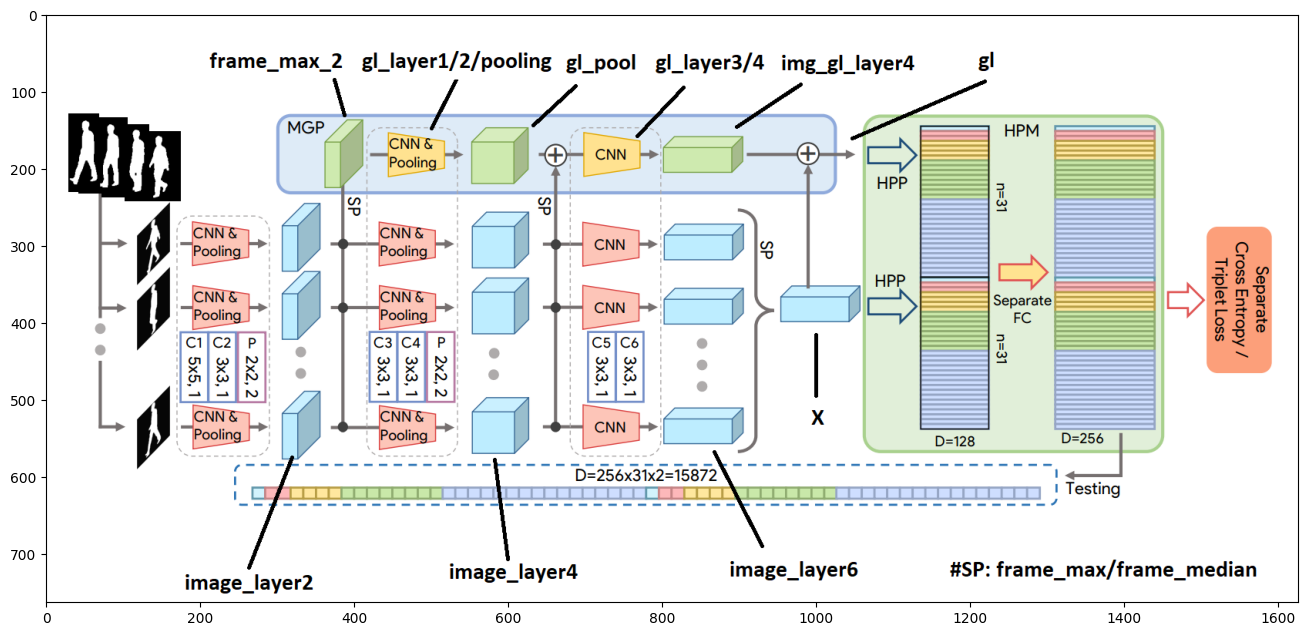

Ảnh trên là mô hình GaitSet, nhóm sẽ tiến hành Import 1 ảnh từ tập CASIA-B để xem kết quả sau giai đoạn 4 sẽ như thế nào.  
Tóm tắt từng bước:  
Input:  
+Một tập hợp các hình ảnh silhouette của một người khi di chuyển.  
Giai đoạn 1: Trích xuất đặc trưng ban đầu  
+Mỗi khung hình silhouette đi qua mạng CNN & Pooling để trích xuất đặc trưng  
Giai đoạn 2: Set Pooling (SP)  
+Sử dụng Set Pooling (SP) để tổng hợp thông tin từ tất cả các khung hình trong cùng một tập dữ liệu.  
+Mục tiêu: Gom nhóm thông tin từ nhiều khung hình để tạo ra một biểu diễn duy nhất cho toàn bộ dáng đi của một người.  
Giai đoạn 3: Multilayer Global Pipeline  (MGP)  
+Sử dụng CNN trích xuất các đặc trưng ở nhiều cấp độ chi tiết khác nhau  
+Giúp mô hình học được thông tin toàn cục và cục bộ của dáng đi  
Giai đoạn 4: Horizontal Pyramid Matching (HPM)  
+HPM giúp trích xuất đặc trưng chi tiết hơn theo chiều dọc của cơ thể.  
+Chia đặc trưng đầu vào thành nhiều phần theo trục dọc và áp dụng pooling để lấy thông tin quan trọng.  
+HPM giúp cải thiện khả năng nhận dạng bằng cách kết hợp thông tin từ các phần khác nhau của ảnh theo nhiều tỷ lệ khác nhau.  
Giai đoạn 5: Phân loại (Classification)  
+Sử dụng Fully Connected Layers (FC) để ánh xạ đặc trưng vào không gian phân loại.  
+Mô hình sử dụng Cross-Entropy Loss hoặc Triplet Loss để huấn luyện.  
+Đầu ra cuối cùng: Một vector đại diện cho danh tính của người đó.

Import thư viện PIL, Torchvision, Matplotlib và Torch để xử lý và hiển thị hình ảnh trong Python

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [ ]:
!git clone https://github.com/AbnerHqC/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 106 (delta 29), reused 22 (delta 22), pack-reused 62 (from 1)
Receiving objects: 100% (106/106), 54.42 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (51/51), done.


Chuẩn bị dữ liệu đầu vào là 1 frame khung hình bất kì trong bộ dữ liệu CASIA-B


*   chuyển ảnh xám vì GaitSet không cần thông tin màu, ảnh xám giúp giảm kich thuoc input, tăng tốc độ train, tập trung vào hình dáng thay vì màu



In [ ]:
path = '/content/006-nm-01-090-039.png'

In [ ]:
img = Image.open(path).convert('L')

Code định nghĩa hàm hiển thị kết quả sau mỗi bước CNN, SetPooling

In [ ]:
def imshow(img):
    plt.imshow(img, cmap="gray")
    plt.axis("off")  # Hide axes
    plt.show()
# Hiển thị toàn bộ feature maps (các kênh đặc trưng) sau một lớp CNN.
def view_image_in_layer(img):
    img = img.squeeze(0).squeeze(0)  # Loại bỏ 2 chiều đầu tiên batch size, số frame: (1, 1, 32, 64, 44) → (32, 64, 44) (num_channels, height, width)

    num_channels = img.shape[0] # Lấy số lượng kênh
    cols = 8  # Số cột hiển thị, ví dụ 8
    rows = (num_channels + cols - 1) // cols  # Tính số hàng cần thiết

    fig, axes = plt.subplots(rows, cols, figsize=(15, 2*rows))
    axes = axes.flatten()  # Chuyển về dạng 1 chiều
  #Vòng lặp hiển thị từng feature map
    for i in range(num_channels):
        axes[i].imshow(img[i].cpu().detach().numpy(), cmap='gray')
        axes[i].set_title(f"Channel {i}")
        axes[i].axis('off')

    # Ẩn các subplot thừa nếu có
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
from GaitSet.model.network.gaitset import SetNet

 Khởi tạo model, 256 là kích thước vector đặc trưng, mỗi người được biểu diễn bằng một vector có 256 phần tử.

In [ ]:
aa = SetNet(256)

chuyển đổi ảnh từ dạng PIL (ảnh bình thường) → thành tensor của PyTorch.
*   Ảnh đầu vào (H, W) -> (C, H, W): C là số kênh màu




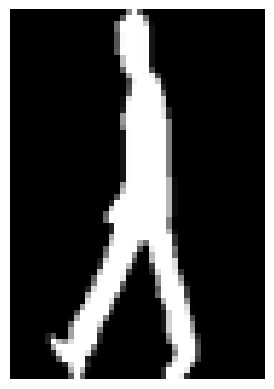

torch.Size([1, 64, 44])

In [ ]:
transform = transforms.ToTensor()
img = img.resize((44, 64))
imshow(img)
img_tensor = transform(img)
img_tensor.shape

In [ ]:
n = img_tensor.size(0) #	Lấy số kênh ảnh (1 cho grayscale)
x = img_tensor.unsqueeze(0) #Thêm chiều num_frames
x = x.unsqueeze(0) #Thêm chiều batch_size

In [ ]:
x.size() #Trả ra tensor shape đúng chuẩn GaitSet

torch.Size([1, 1, 1, 64, 44])

C1 (1, 1, 44, 64) * (32, 1, 5, 5) -> (1, 32, 44, 64) (padding 2)

set_layer1 là một tầng Convolution 2D (CNN), mục đích: trích xuất các đặc trưng(Biên, góc, cạnh, vùng đậm/nhạt-> nền tảng dáng người)


*   cấu trúc Conv2D thường có: **nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, stride=1)**
*   H = 64, W = 44
kernel = 5, padding = 2, stride = 1, output có kích thước giữ nguyên, nhưng có 32 kênh đặc trưng.
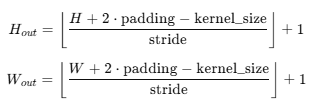
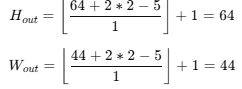

torch.Size([1, 1, 32, 64, 44])


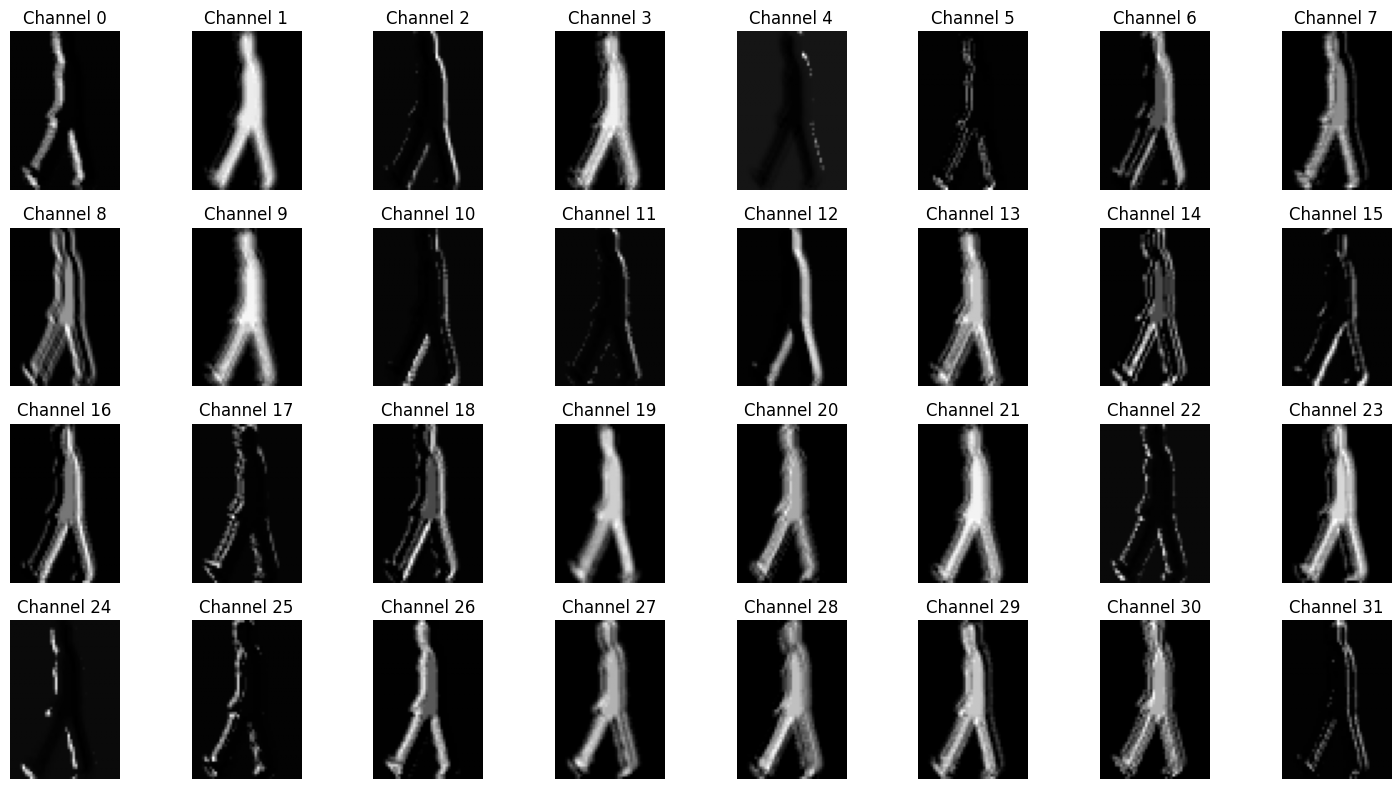

In [ ]:
img_layer1 = aa.set_layer1(x)
print(img_layer1.shape)
view_image_in_layer(img_layer1)

C2 (1, 32, 44, 64) * (32, 32, 3, 3) -> (1, 32, 22, 32) (padding 1, downsampling)

**Đưa output từ set_layer1 qua tầng CNN thứ 2 (set_layer2)**


*   set_layer2() tiếp tục dùng Conv2D để: tăng chiều sâu đặc trưng, giảm kích thước không gian (downsampling)
*  Trong GaitSet gốc, set_layer2:
***nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)***
- Đầu vào có 32 kênh từ layer trước, Giữ nguyên số filter, filter là ma trận 3×3, padding 1 để ko giảm quá nhiều kthuoc, stride = 2: Downsampling: giảm kích thước đầu ra xuống còn 1/2
- Áp công thưc -> Output shape: (1, 1, 32, 32, 22)
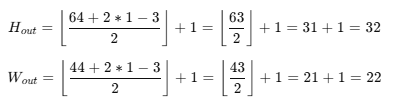

torch.Size([1, 1, 32, 32, 22])


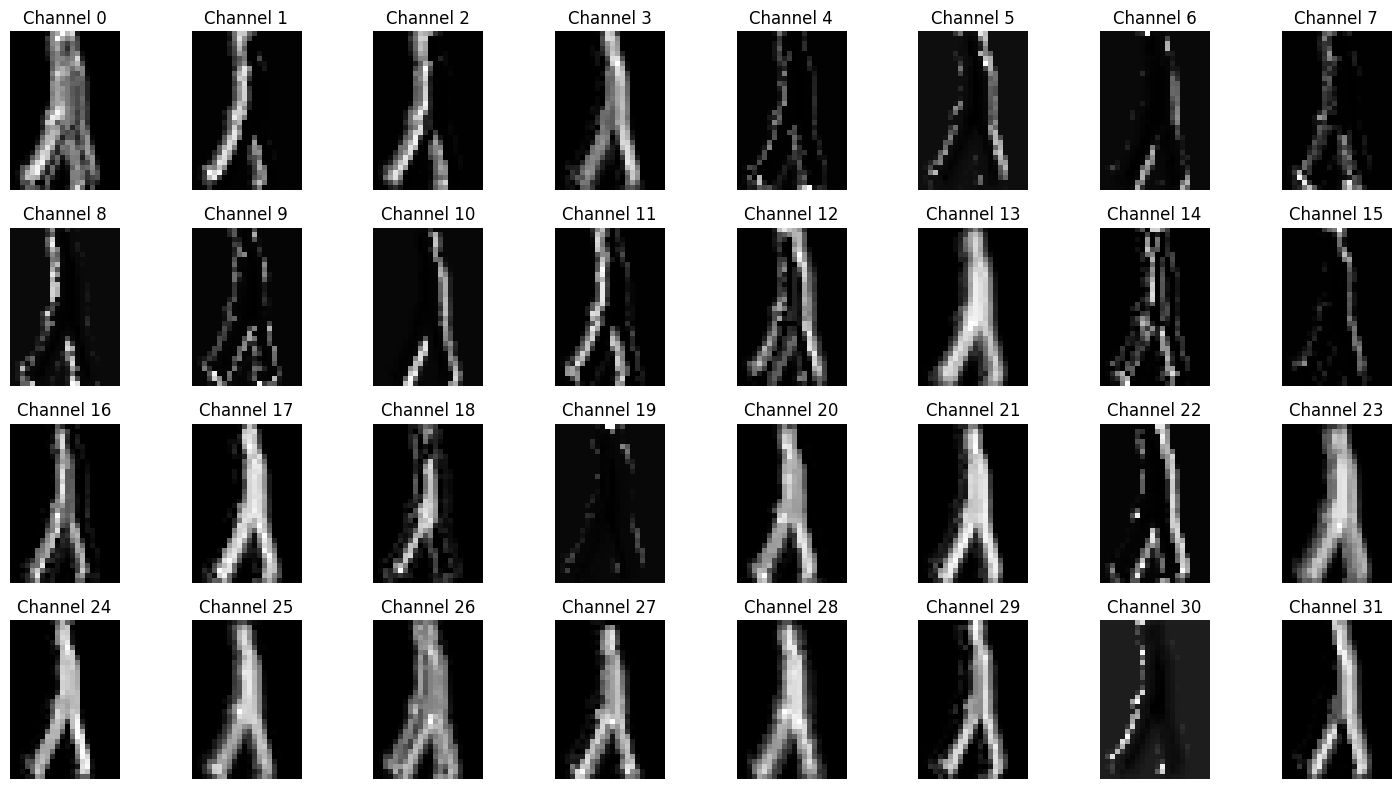

In [ ]:
img_layer2 = aa.set_layer2(img_layer1)
print(img_layer2.shape)
view_image_in_layer(img_layer2)

SP (1, 32, 22, 32)

 **Set Pooling (frame_max) để gộp đặc trưng từ nhiều frame thành 1 biểu diễn duy nhất**

*   input shape (batch_size, num_frames, channels, H, W),
frame_max() thực hiện:
output = torch.max(input, dim=1)
- dim=1 → gộp theo frame (chiều thứ 2 trong tensor)
- torch.max() trả về:

  + giá trị lớn nhất tại mỗi điểm (channel, x, y) trên tất cả các frame

  +  output shape là (batch_size, channels, H, W)
+img_layer2.shape = (1, 1, 32, 32, 22)
→ Output sẽ là: (1, 32, 32, 22)
Vì chỉ có 1 frame, nên thực tế giá trị giữ nguyên (không có gì để "max").
- frame_max_2[0] có shape: (1, 32, 32, 22)
→ Đây là kết quả sau khi gộp frame bằng frame_max()
→ Ý nghĩa: 32 kênh đặc trưng, ảnh có size 32×22



torch.Size([1, 32, 32, 22])


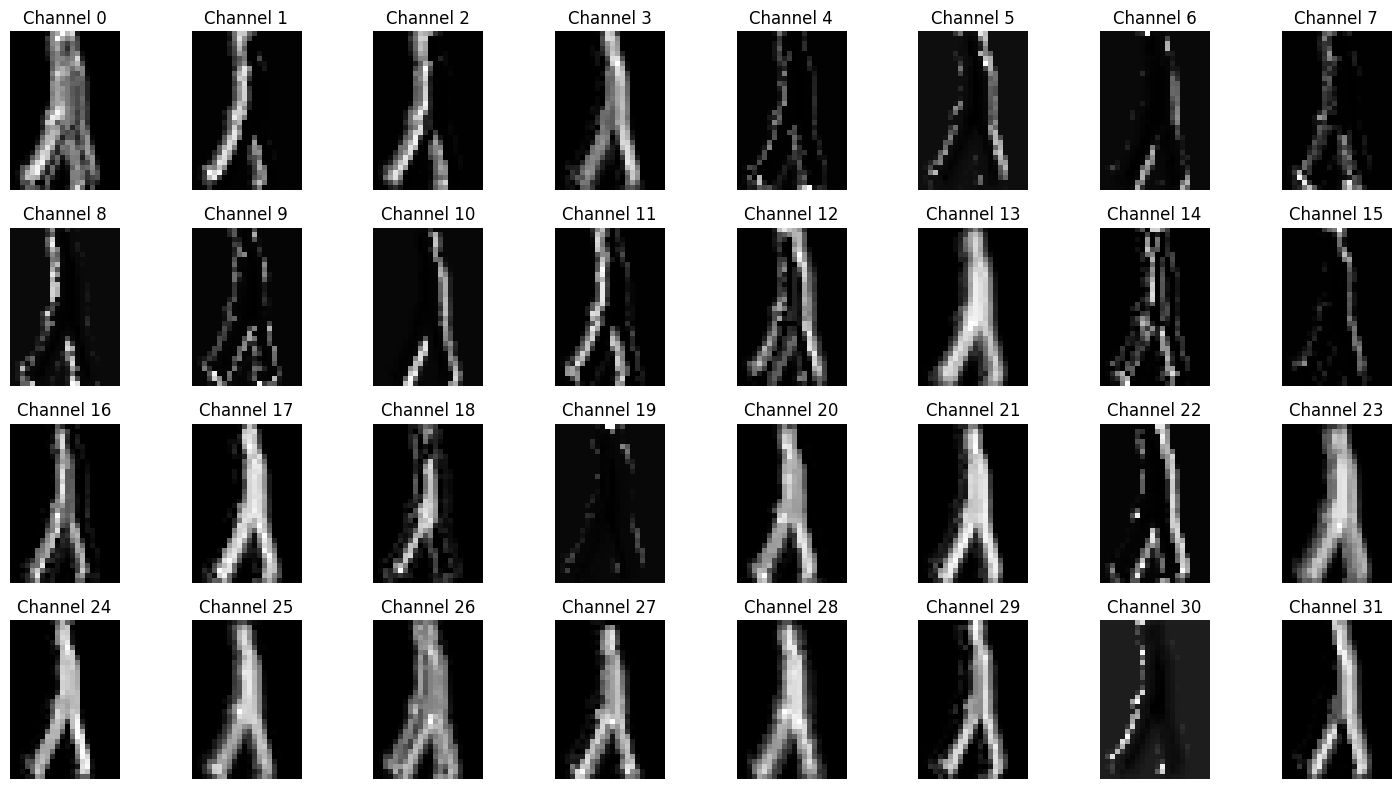

In [ ]:
frame_max_2 = aa.frame_max(img_layer2)
print(frame_max_2[0].shape)
view_image_in_layer(frame_max_2[0])

(1, 32, 22, 32) * (64, 32, 3, 3) -> (1, 64, 22, 32) (padding 1)

** giai đoạn Global Feature Extraction**
- Áp dụng một tầng Conv2D toàn cục (gl_layer1) để trích xuất đặc trưng phức tạp hơn

- Kết quả là tensor chứa 64 kênh đặc trưng (feature maps)
- gl_layer1 là một tầng nn.Conv2d: **nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)**
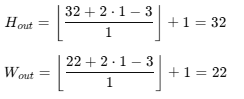
- Tăng số lượng feature maps: Từ 32 → 64 giúp học được đặc trưng phức tạp hơn, giàu thông tin hơn




torch.Size([1, 64, 32, 22])


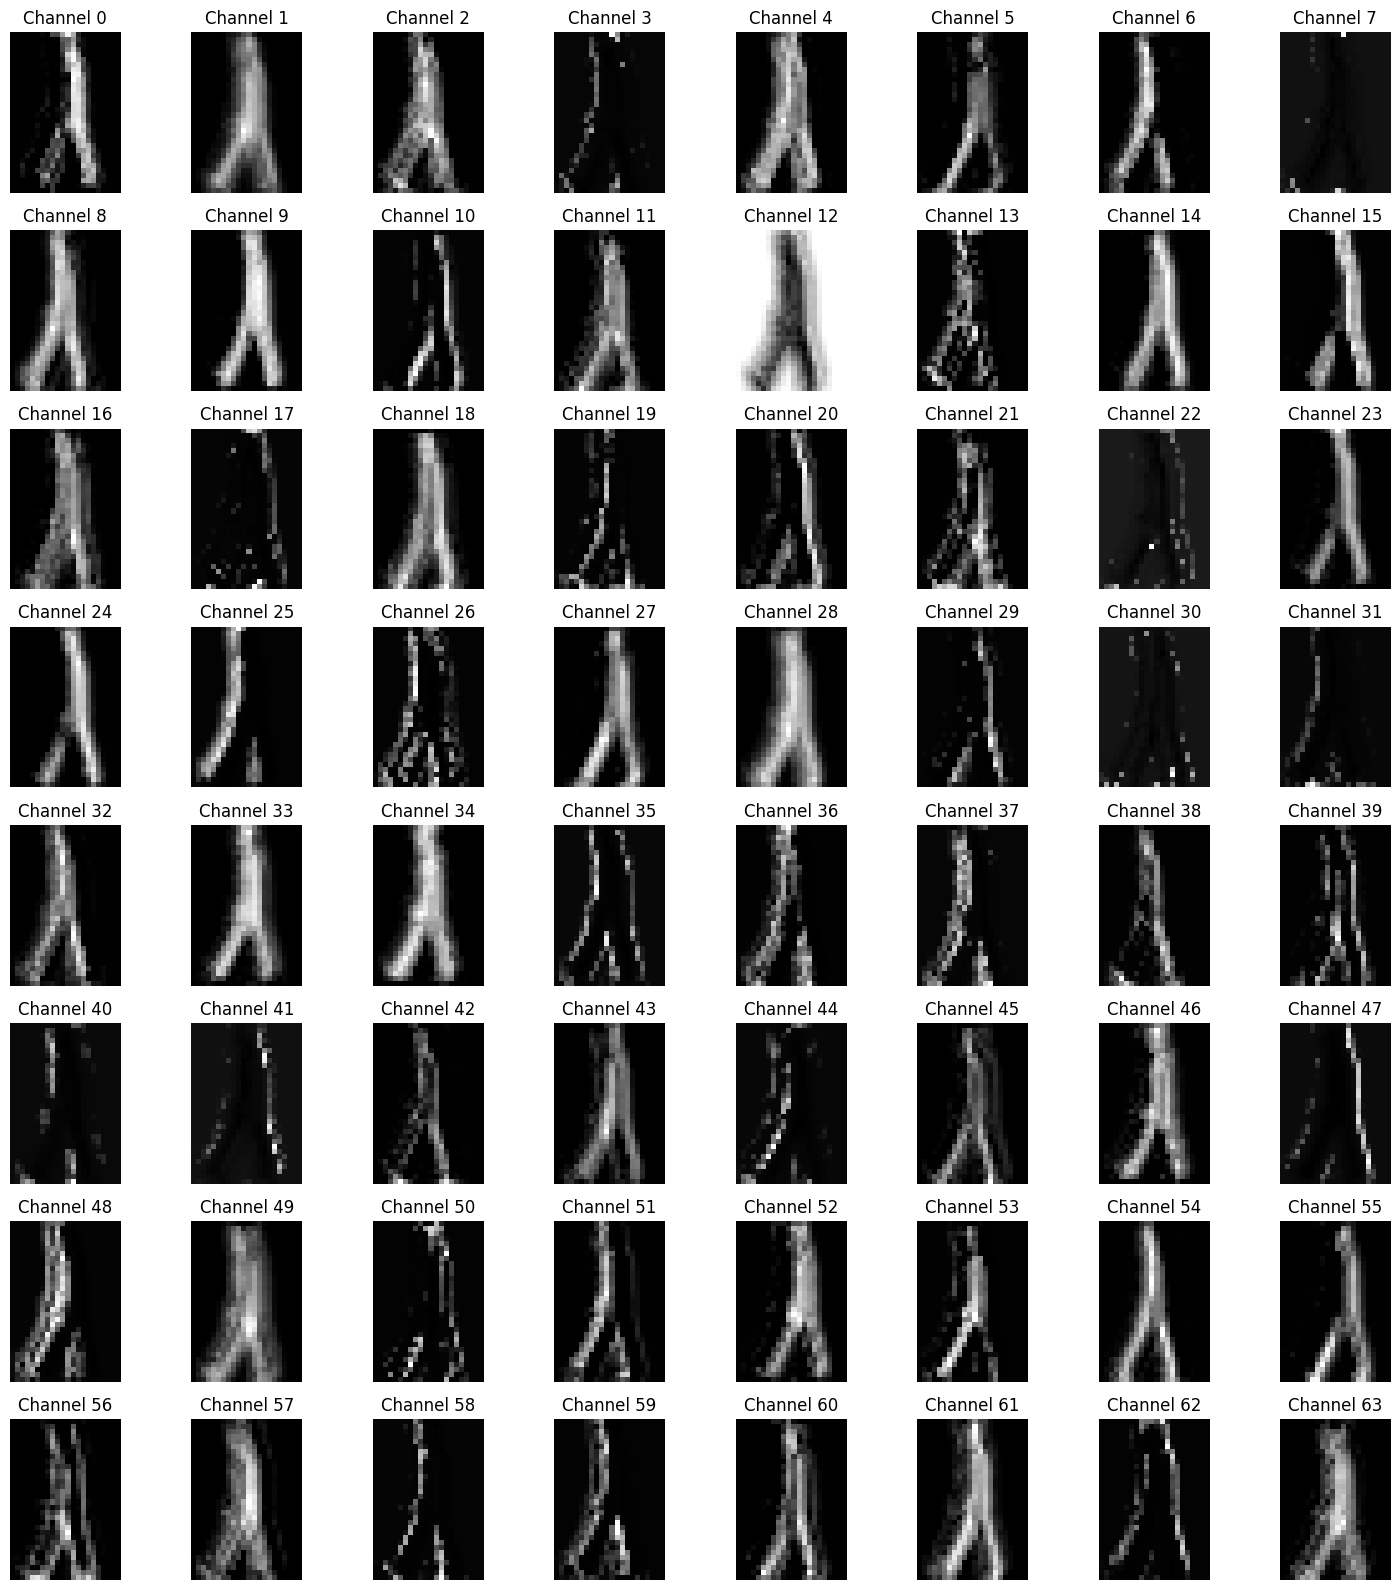

In [ ]:
img_gl_layer1 = aa.gl_layer1(frame_max_2[0])
print(img_gl_layer1.shape)
view_image_in_layer(img_gl_layer1)

**Đưa kết quả từ gl_layer1 qua tầng CNN tiếp theo — gl_layer2**
- Trong mô hình GaitSet, gl_layer2: **nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)**
- Áp dụng công thức: Output shape vẫn là (1, 64, 32, 22)



torch.Size([1, 64, 32, 22])


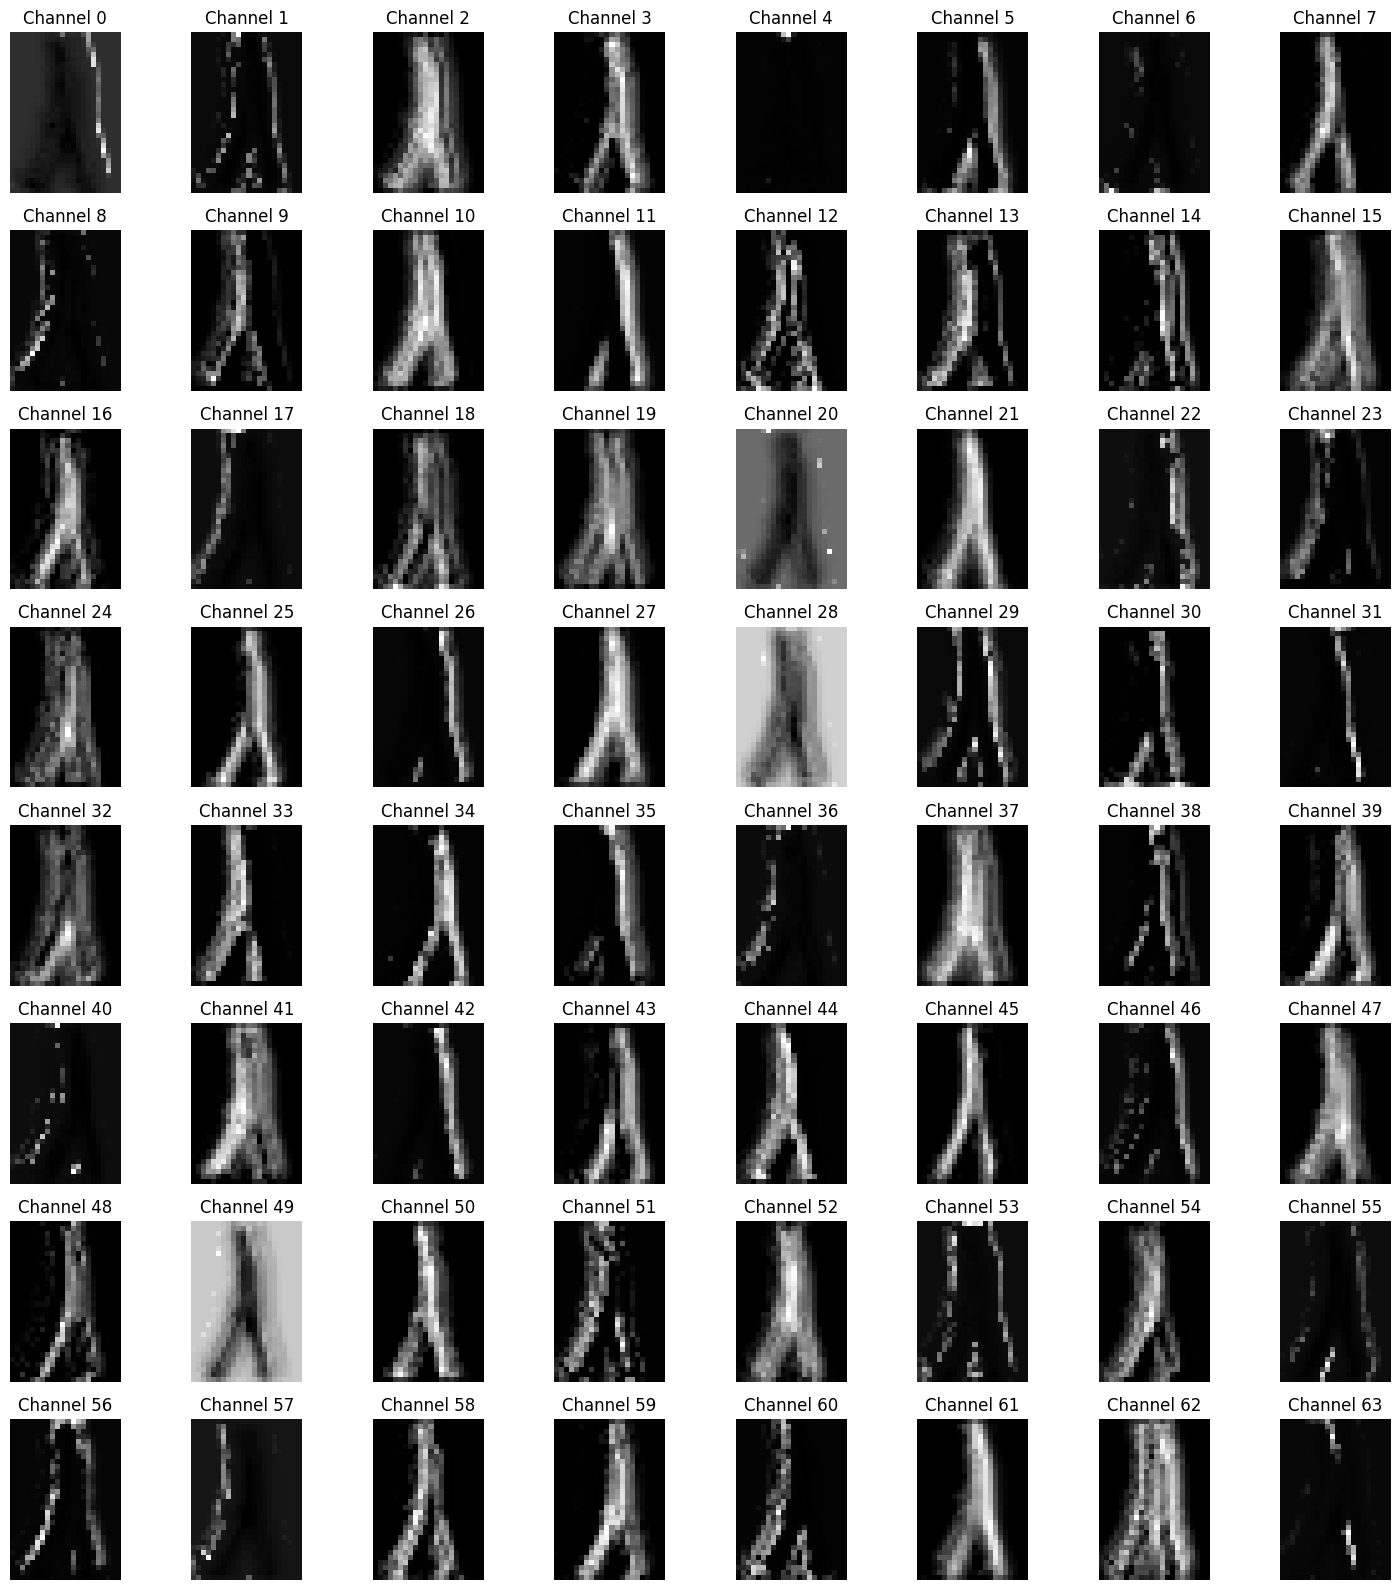

In [ ]:
img_gl_layer2 = aa.gl_layer2(img_gl_layer1)
print(img_gl_layer2.shape)
view_image_in_layer(img_gl_layer2)

Pooling (1, 64, 16, 16)

**Max Pooling:**
Là phép toán để giảm kích thước ảnh đầu vào bằng cách:

- Chia ảnh thành từng ô nhỏ (ví dụ 2×2)
- Lấy giá trị lớn nhất trong mỗi ô

=> Giúp: Giảm số lượng điểm ảnh → giảm tính toán. Giữ lại đặc trưng nổi bật nhất
- Trong GaitSet, gl_pooling: **nn.MaxPool2d(kernel_size=2, stride=2)**
- Cách hđ:
  - Với ảnh đầu vào size 32×22:

    height: 32 → 16 (chia đôi)

    width: 22 → 11 (chia đôi)
=> Kết quả: gl_pool.shape = (1, 64, 16, 11)


torch.Size([1, 64, 16, 11])


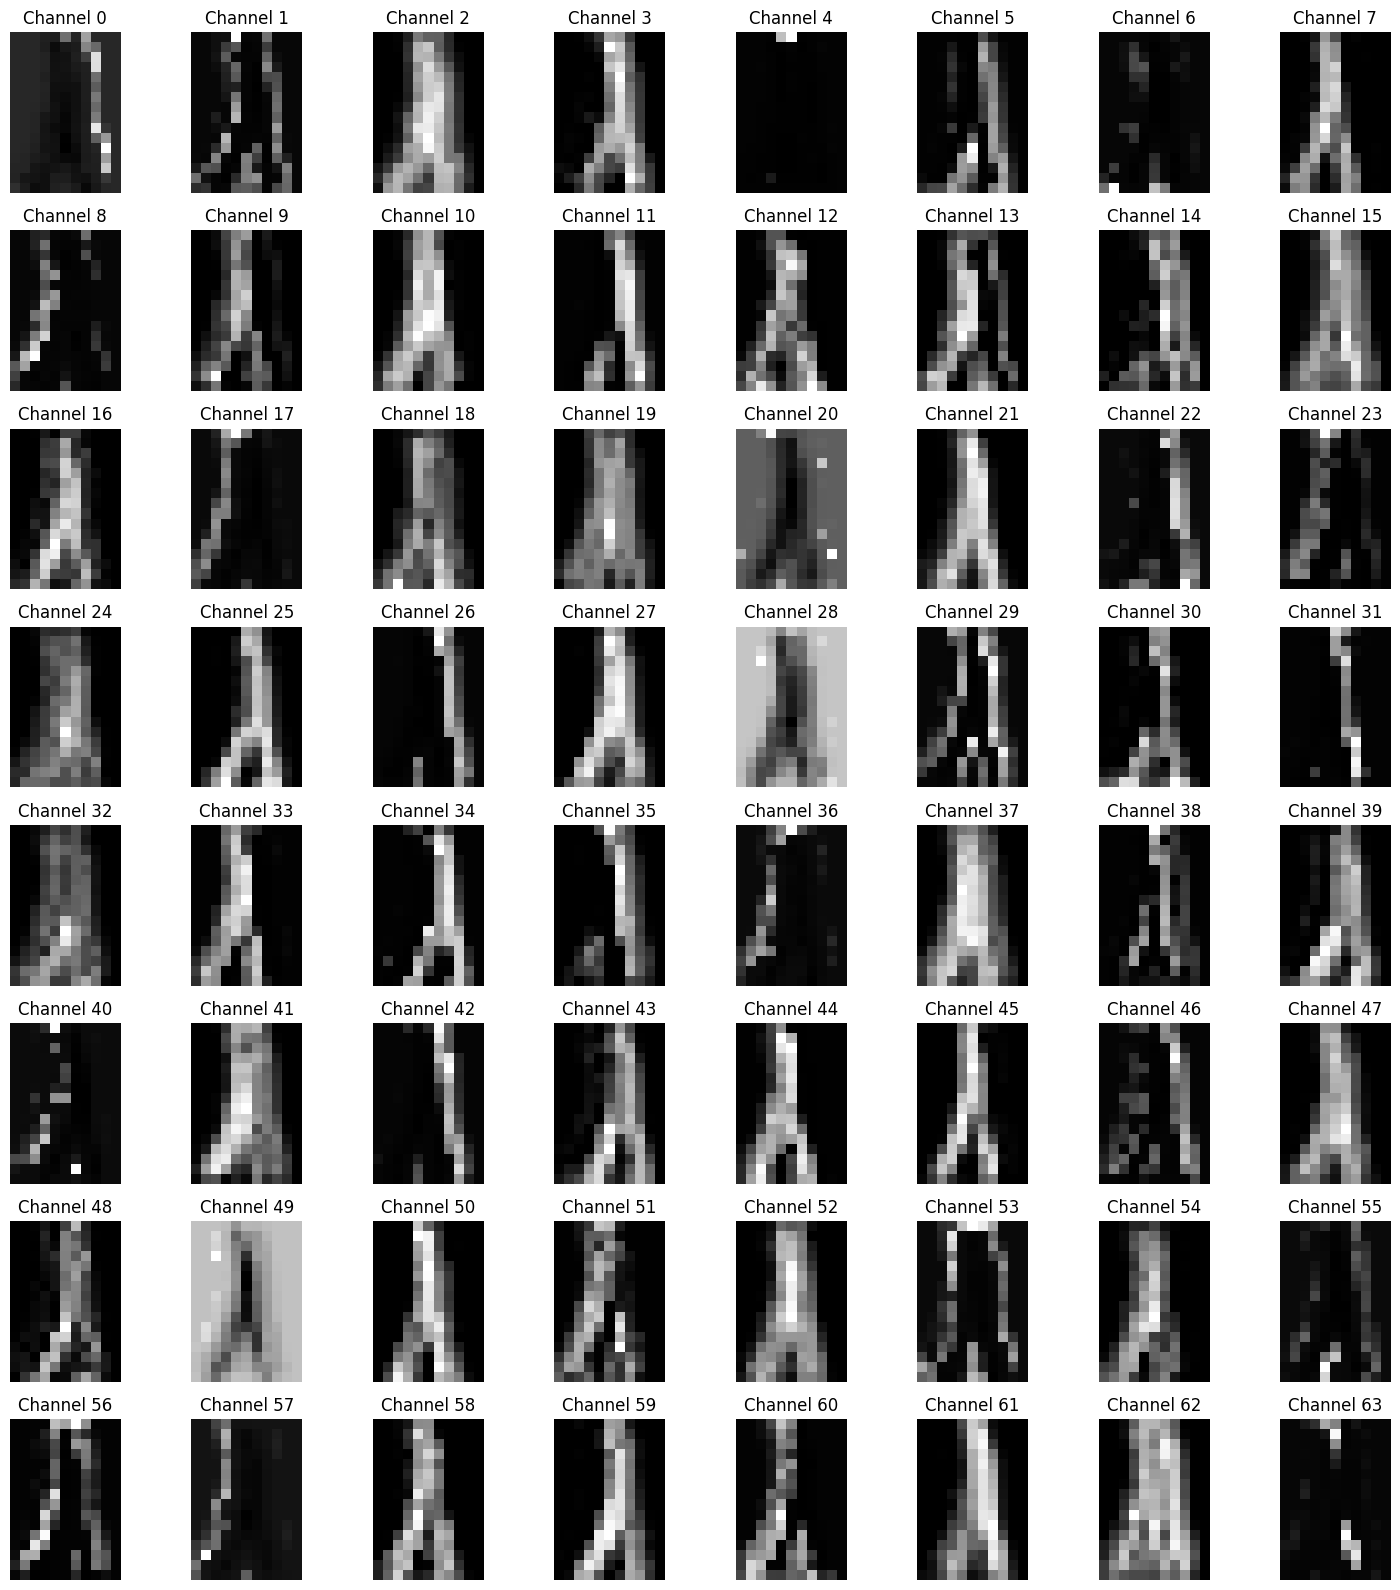

In [ ]:
gl_pool = aa.gl_pooling(img_gl_layer2)
print(gl_pool.shape)
view_image_in_layer(gl_pool)

C3 (1, 32, 32, 32) * (64, 32, 3, 3) -> (1, 64, 32, 32) (padding 1)

**Đưa kết quả từ tầng set_layer2 qua tầng CNN thứ 3 – set_layer3**: Tăng số lượng kênh đặc trưng (feature maps) từ 32 → 64. Giữ nguyên kích thước không gian (height × width)
- Ở bước trước: **img_layer2.shape = (1, 1, 32, 32, 22)** 1 batch, 1 frame
- set_layer3 là một tầng 2D Convolution áp dụng trên từng frame (giống như set_layer1, set_layer2): **nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)**
- Tính toán Output: (HxW)=(32, 22): Kích thước không gian không thay đổi


torch.Size([1, 1, 64, 32, 22])


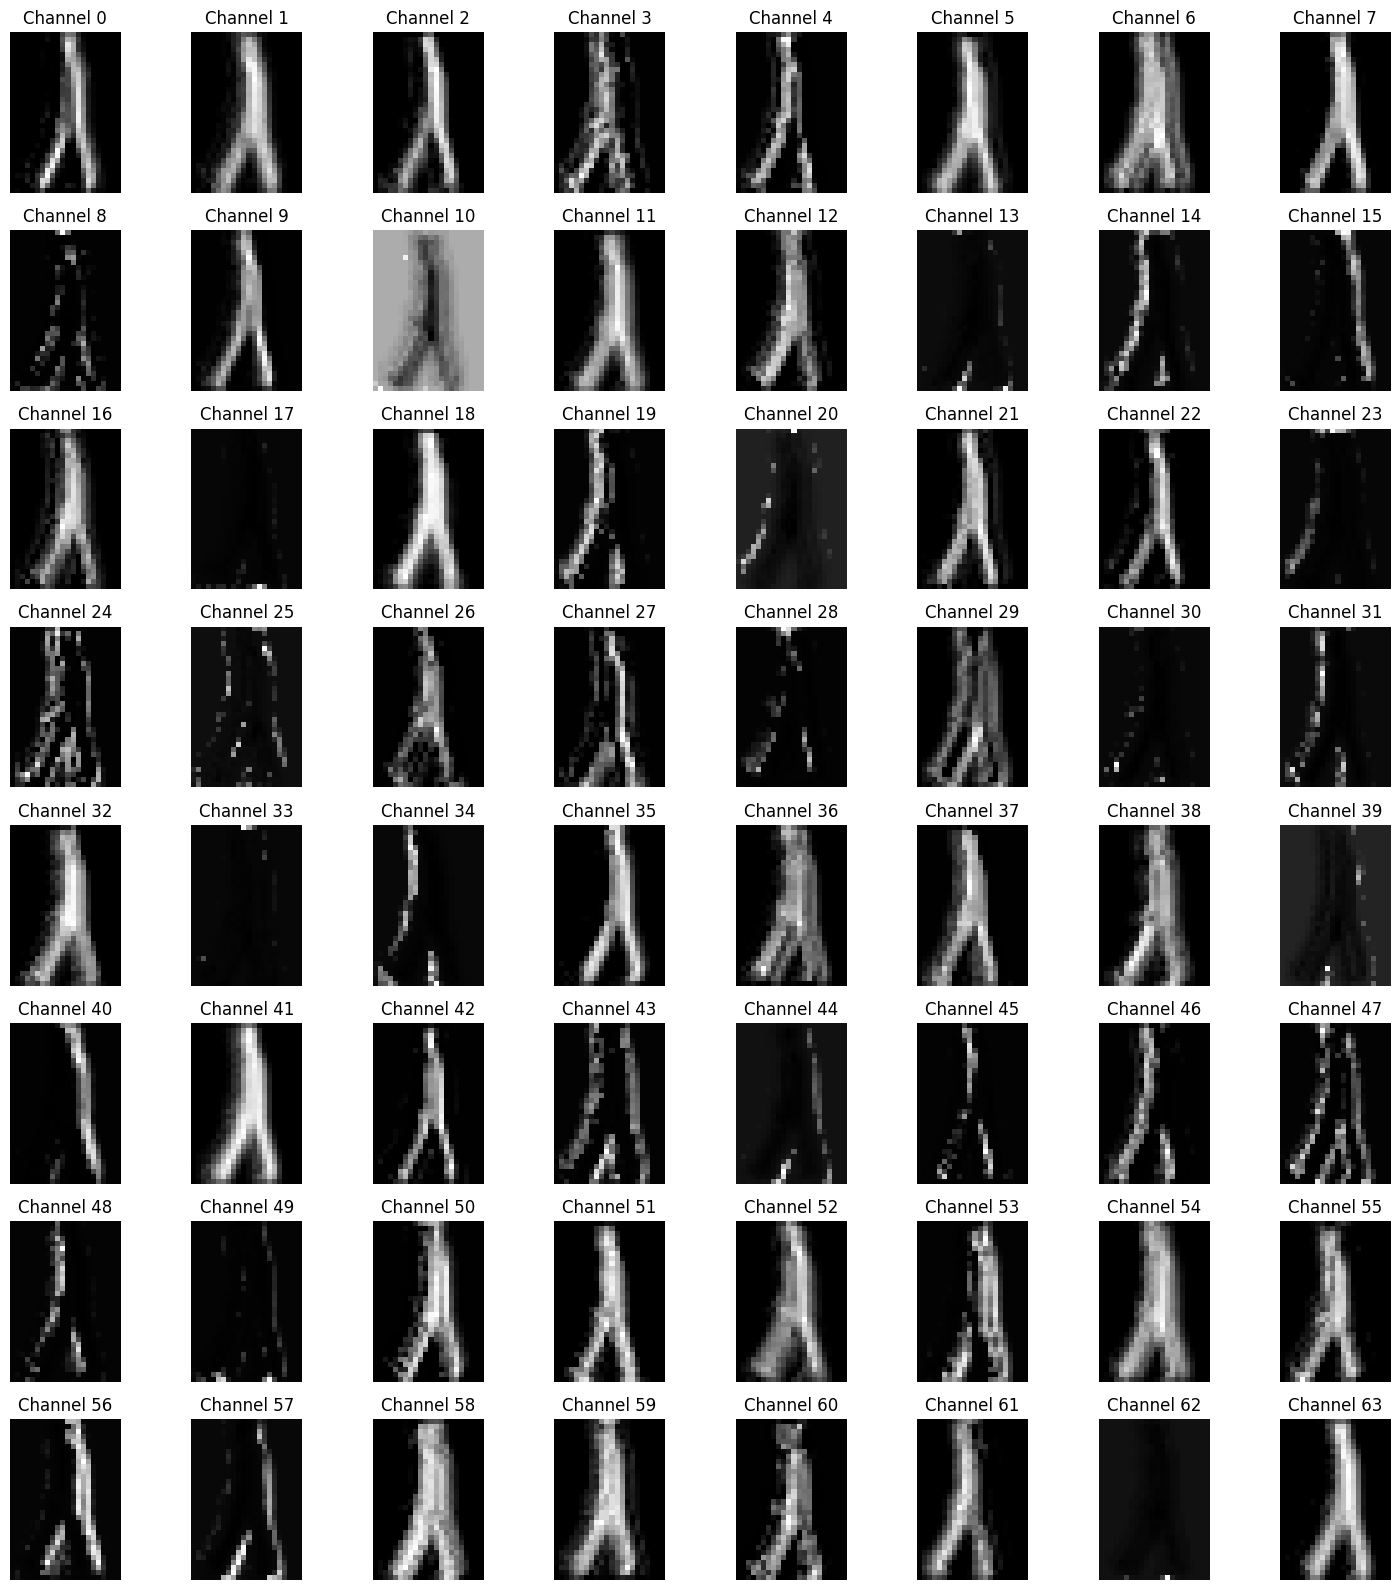

In [ ]:
img_layer3 = aa.set_layer3(img_layer2)
print(img_layer3.shape)
view_image_in_layer(img_layer3)

C4 (1, 64, 22, 32) * (64, 64, 3, 3) -> (1, 64, 11, 16) (padding1, downsampling)

**tầng set_layer4, có vai trò giảm kích thước đặc trưng không gian (spatial) trong khi giữ nguyên số lượng kênh để chuẩn bị cho bước gộp frame (Set Pooling).**
- set_layer4: **nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)** -> Giảm kích thước ảnh (downsampling) để rút gọn thông tin. Giữ nguyên số lượng kênh (64) → vẫn giữ độ biểu diễn mạnh

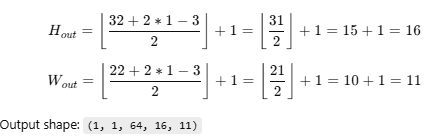


torch.Size([1, 1, 64, 16, 11])


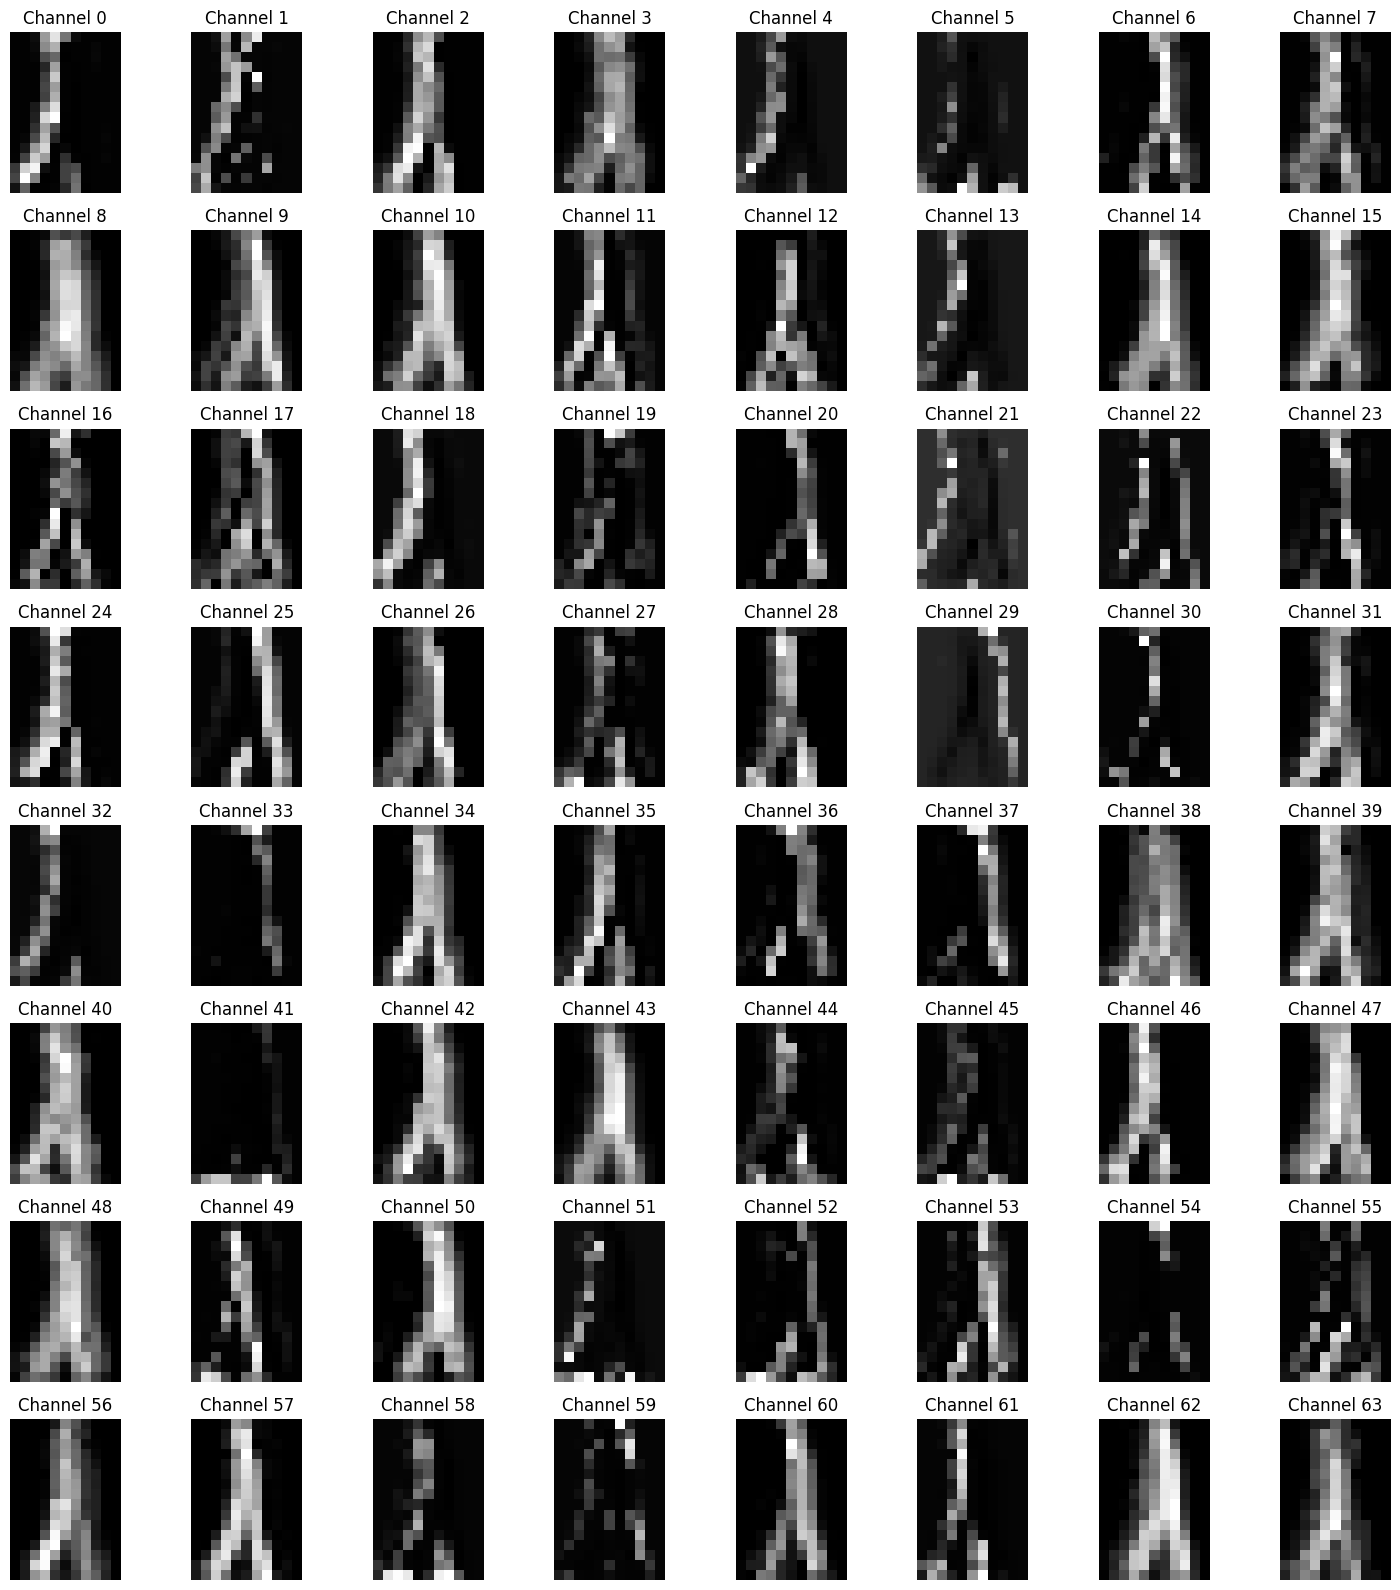

In [ ]:
img_layer4 = aa.set_layer4(img_layer3)
print(img_layer4.shape)
view_image_in_layer(img_layer4)

SP (1, 64, 16, 16)

Set Pooling (frame_max) lần 2 để gộp đặc trưng từ nhiều frame thành một đại diện duy nhất
- frame_max: Là Set Pooling theo chiều frame (dim=1)

- Thực hiện max pooling trên tất cả các frame để chọn ra giá trị lớn nhất tại mỗi điểm (channel, x, y)

- Công thức: **frame_max = torch.max(input, dim=1, keepdim=True)** Chỉ có 1 frame duy nhất, nên max() giữ nguyên giá trị
- frame_max_4.shape = (1, 1, 64, 16, 11)
  - Sau đó frame_max_4[0] → lấy ra phần tử đầu tiên của batch

  - frame_max_4[0].shape = (1, 64, 16, 11)



torch.Size([1, 64, 16, 11])


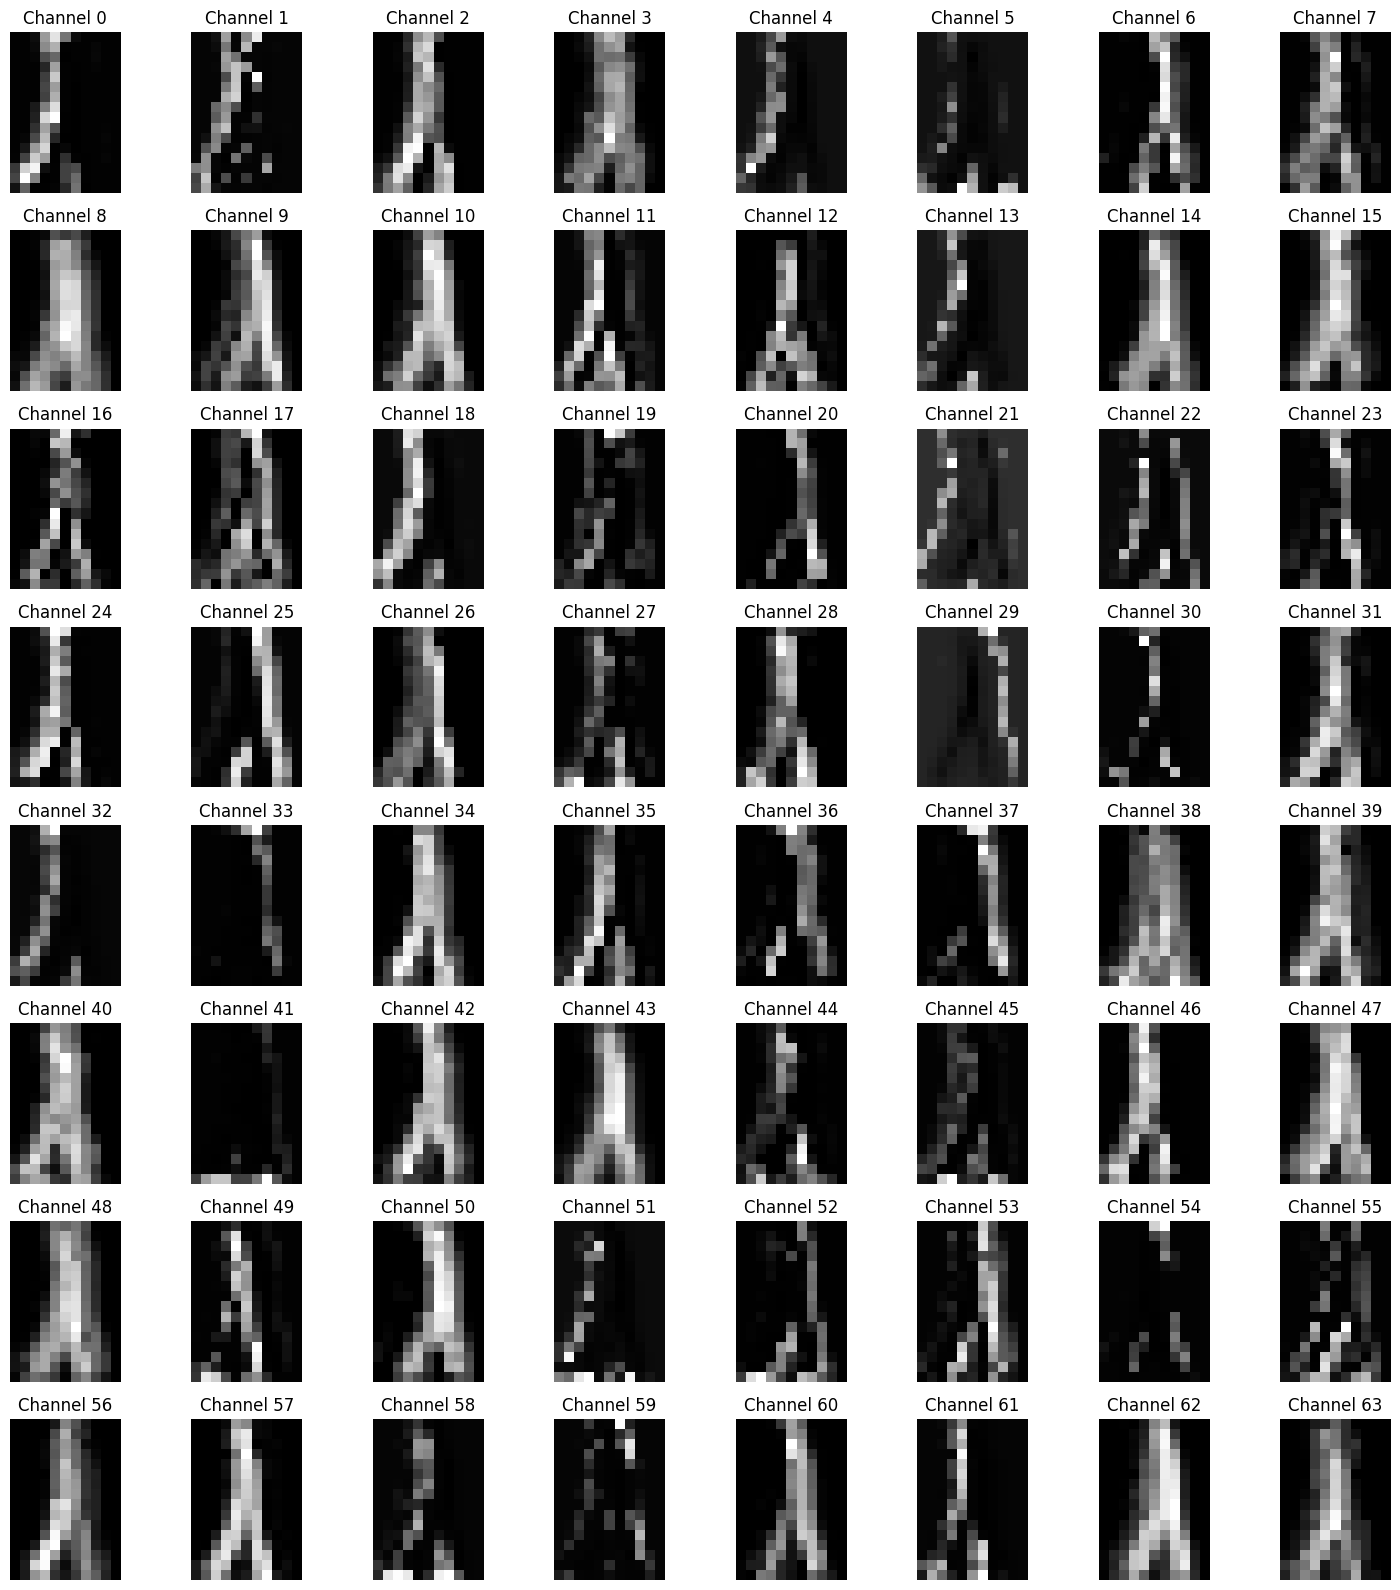

In [ ]:
frame_max_4 = aa.frame_max(img_layer4)
print(frame_max_4[0].shape)
view_image_in_layer(frame_max_4[0])

(1, 64, 16, 16) * (128, 64, 3, 3) -> (1, 128, 16, 16) (pading 1)

**tổng hợp đặc trưng từ hai nhánh: nhánh global (gl_pool) và nhánh set (frame_max).Đưa tổng hợp này qua một lớp CNN (gl_layer3) để học tiếp đặc trưng sâu hơn**
- cộng lại để có đặc trưng giàu thông tin hơn.

- gl_layer3 là một tầng Conv2D với: **nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)**

Input shape: (1, 64, 16, 11)

Output shape: (1, 128, 16, 11)

Số kênh tăng từ 64 → 128, không gian giữ nguyên.
Vẽ 128 ảnh xám, tương ứng với 128 đặc trưng học được

Mỗi ảnh là kết quả của 1 filter áp dụng lên đặc trưng tổng hợp giữa global và set



torch.Size([1, 128, 16, 11])


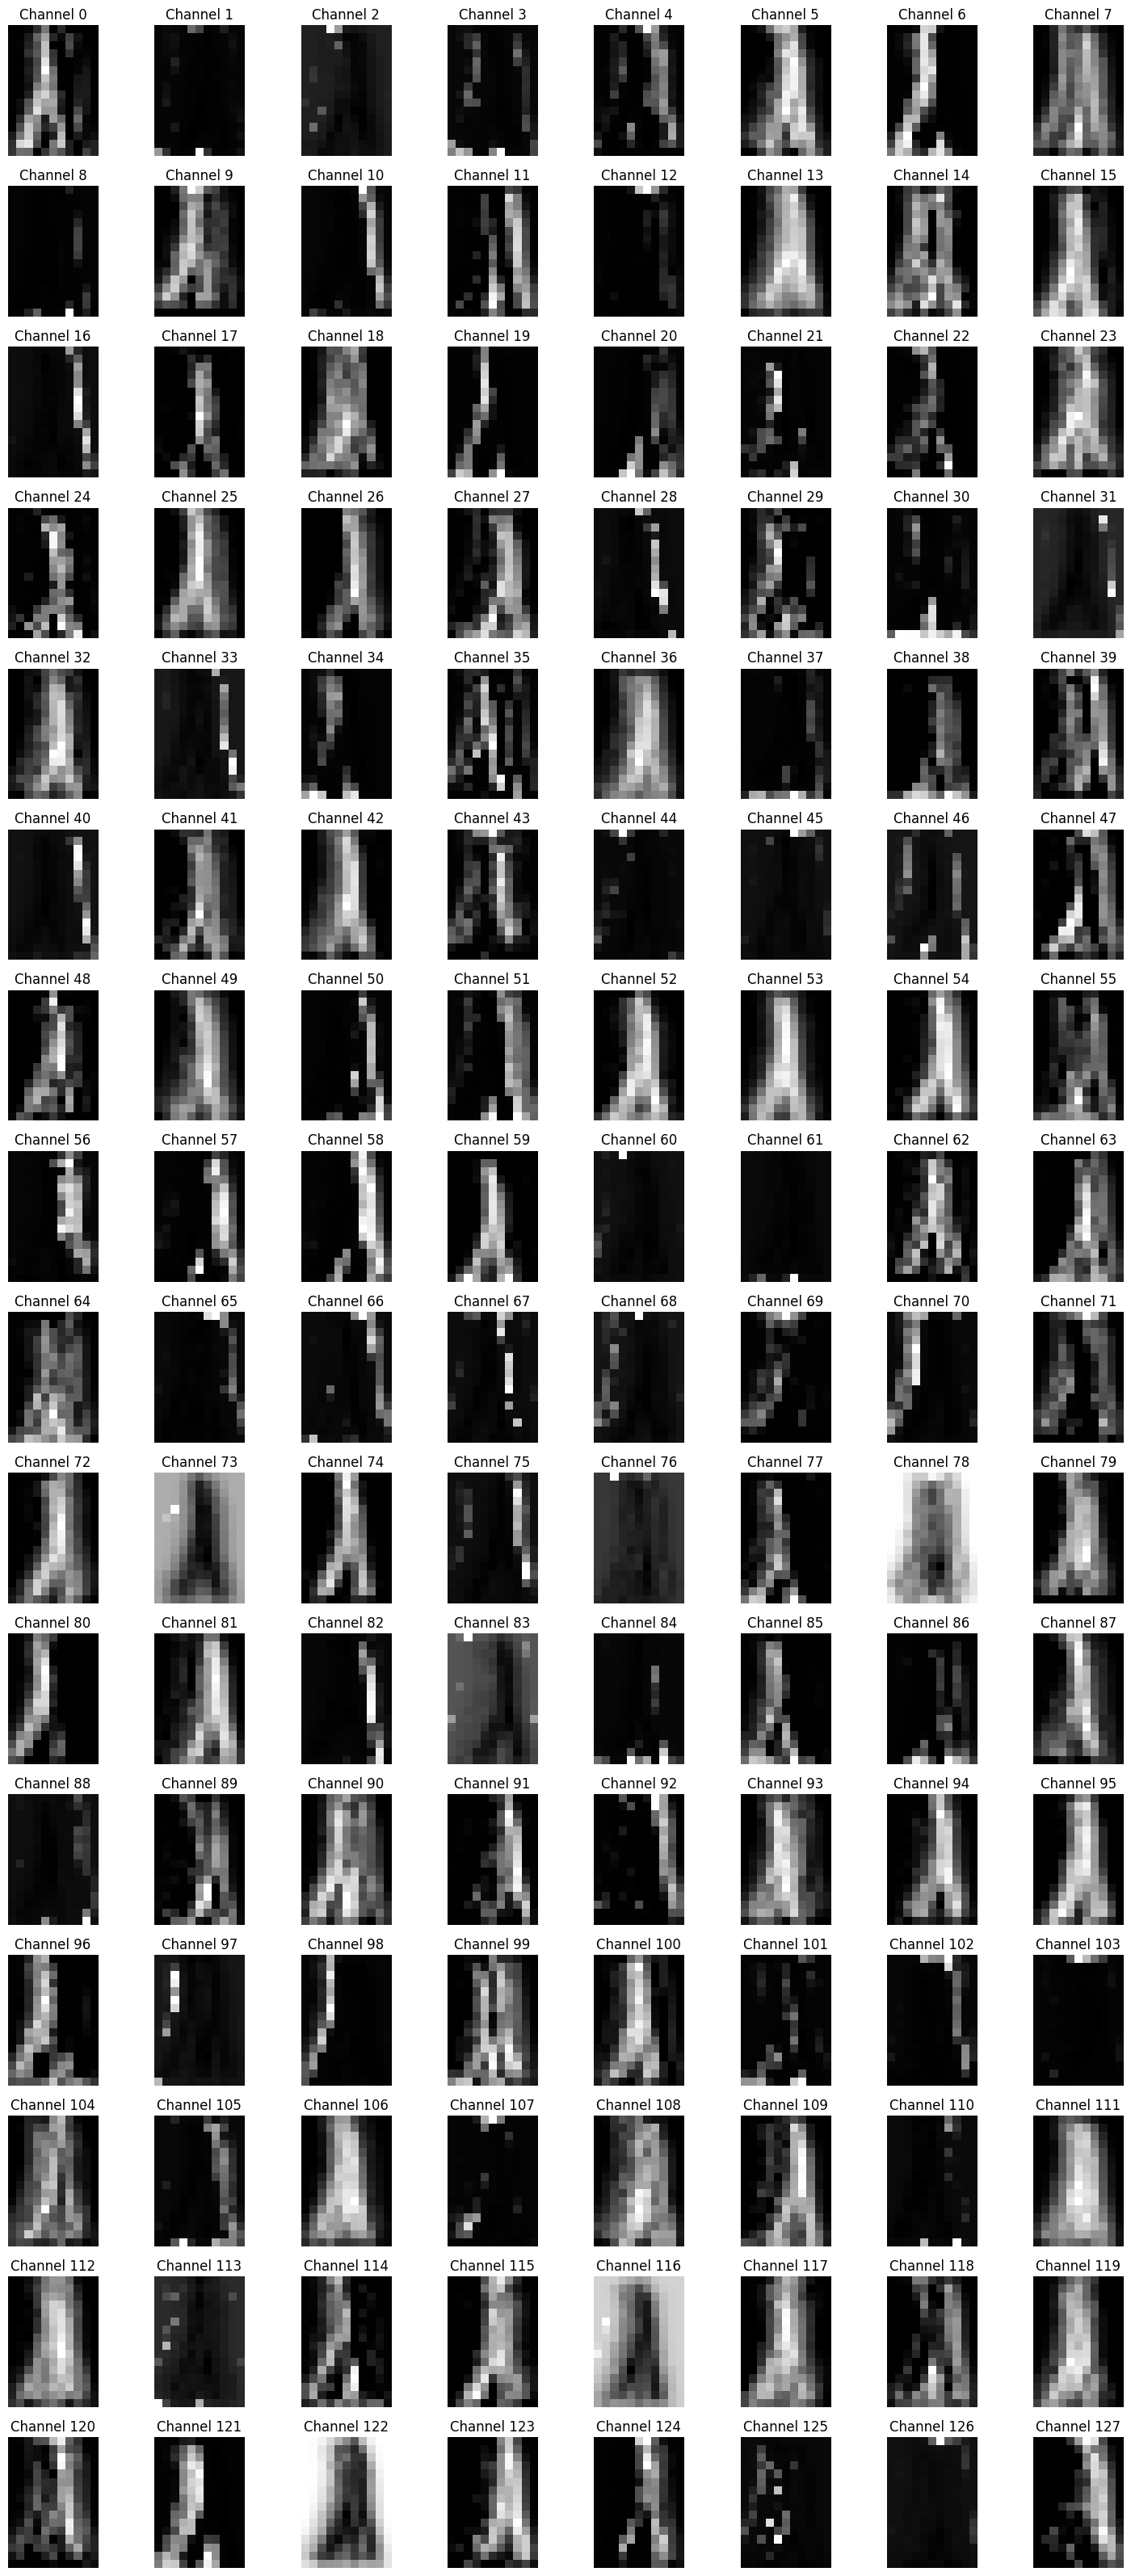

In [ ]:
img_gl_layer3 = aa.gl_layer3(gl_pool + frame_max_4[0])
print(img_gl_layer3.shape)
view_image_in_layer(img_gl_layer3)

(1, 128, 16, 16) * (128, 128, 3, 3) -> (1, 128, 16, 16) (padding 1)

**tầng CNN cuối cùng trong nhánh Global**

 Áp dụng tầng convolution cuối (gl_layer4) để tiếp tục trích đặc trưng sau khi đã kết hợp toàn bộ thông tin

Giữ nguyên shape, nhưng tăng khả năng biểu diễn (representation power)
- gl_layer4: **nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)**
- Vì stride=1, padding=1, kernel=3, nên giữ nguyên chiều không gian: (1, 128, 16, 11)

torch.Size([1, 128, 16, 11])


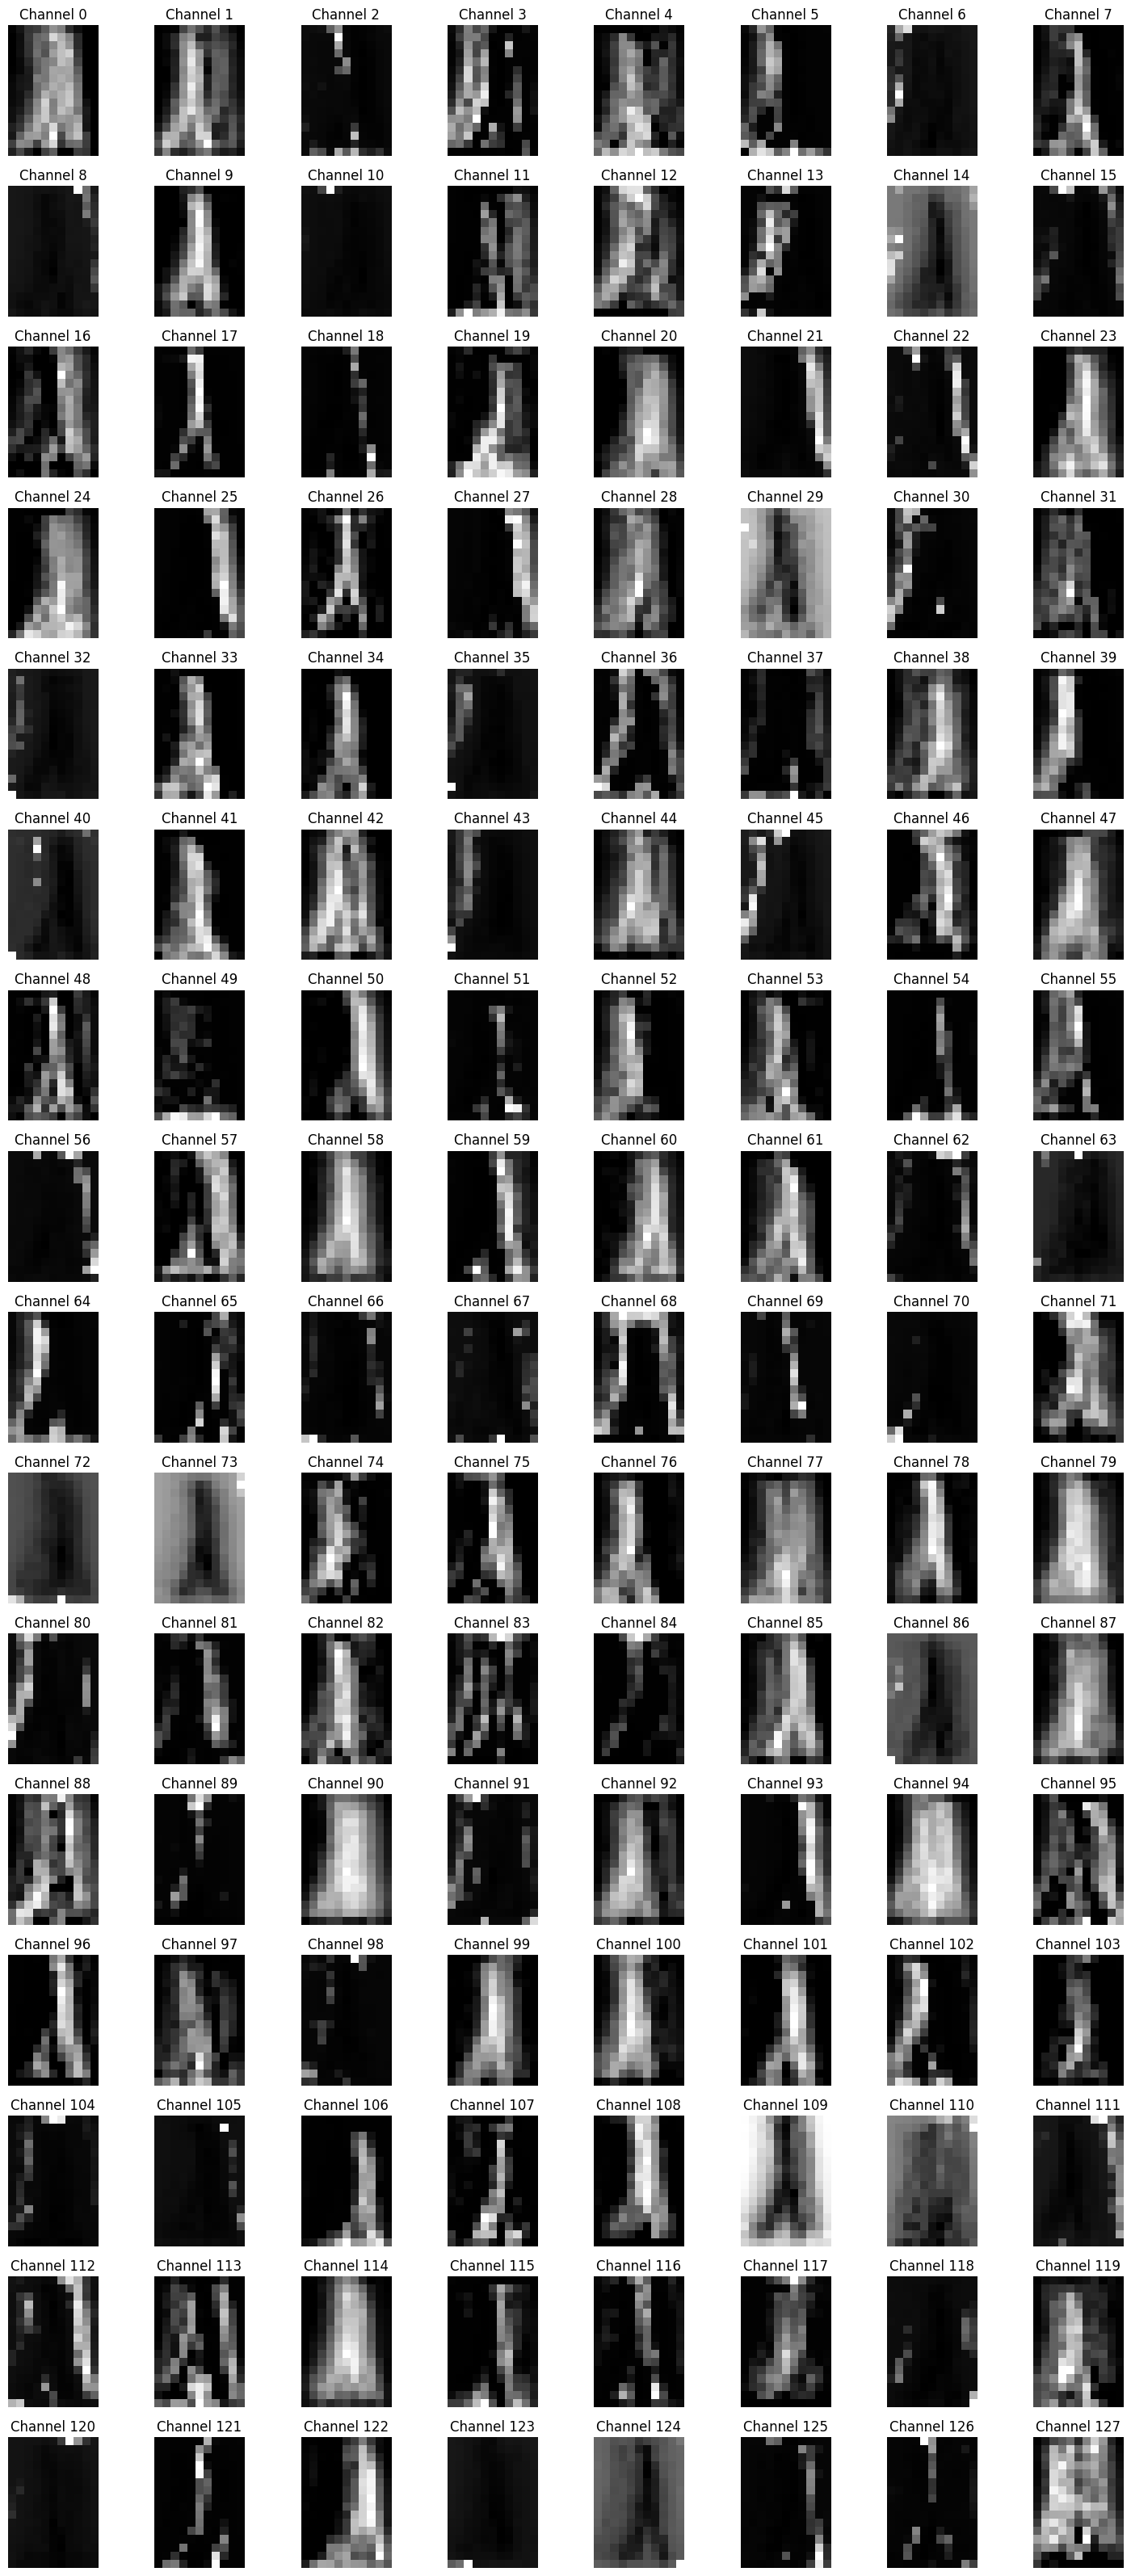

In [ ]:
img_gl_layer4 = aa.gl_layer4(img_gl_layer3)
print(img_gl_layer4.shape)
view_image_in_layer(img_gl_layer4)

C5 (1, 64, 16, 16) * (128, 64, 3, 3) -> (1, 128, 16, 16) (padding 1)

Áp dụng một tầng CNN cuối cùng trong nhánh Set để:

Tăng chiều kênh từ 64 → 128

Giữ nguyên kích thước không gian
- set_layer5: **nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)** vì mô hình xử lý từng frame riêng lẻ, nên lớp này được áp dụng lên từng frame thông qua một vòng lặp hoặc reshape phù hợp.

Input: (1, 1, 64, 16, 11) : set_layer4

Output: (1, 1, 128, 16, 11)

Tăng chiều sâu: Từ 64 → 128 giúp tăng khả năng phân biệt dáng đi



torch.Size([1, 1, 128, 16, 11])


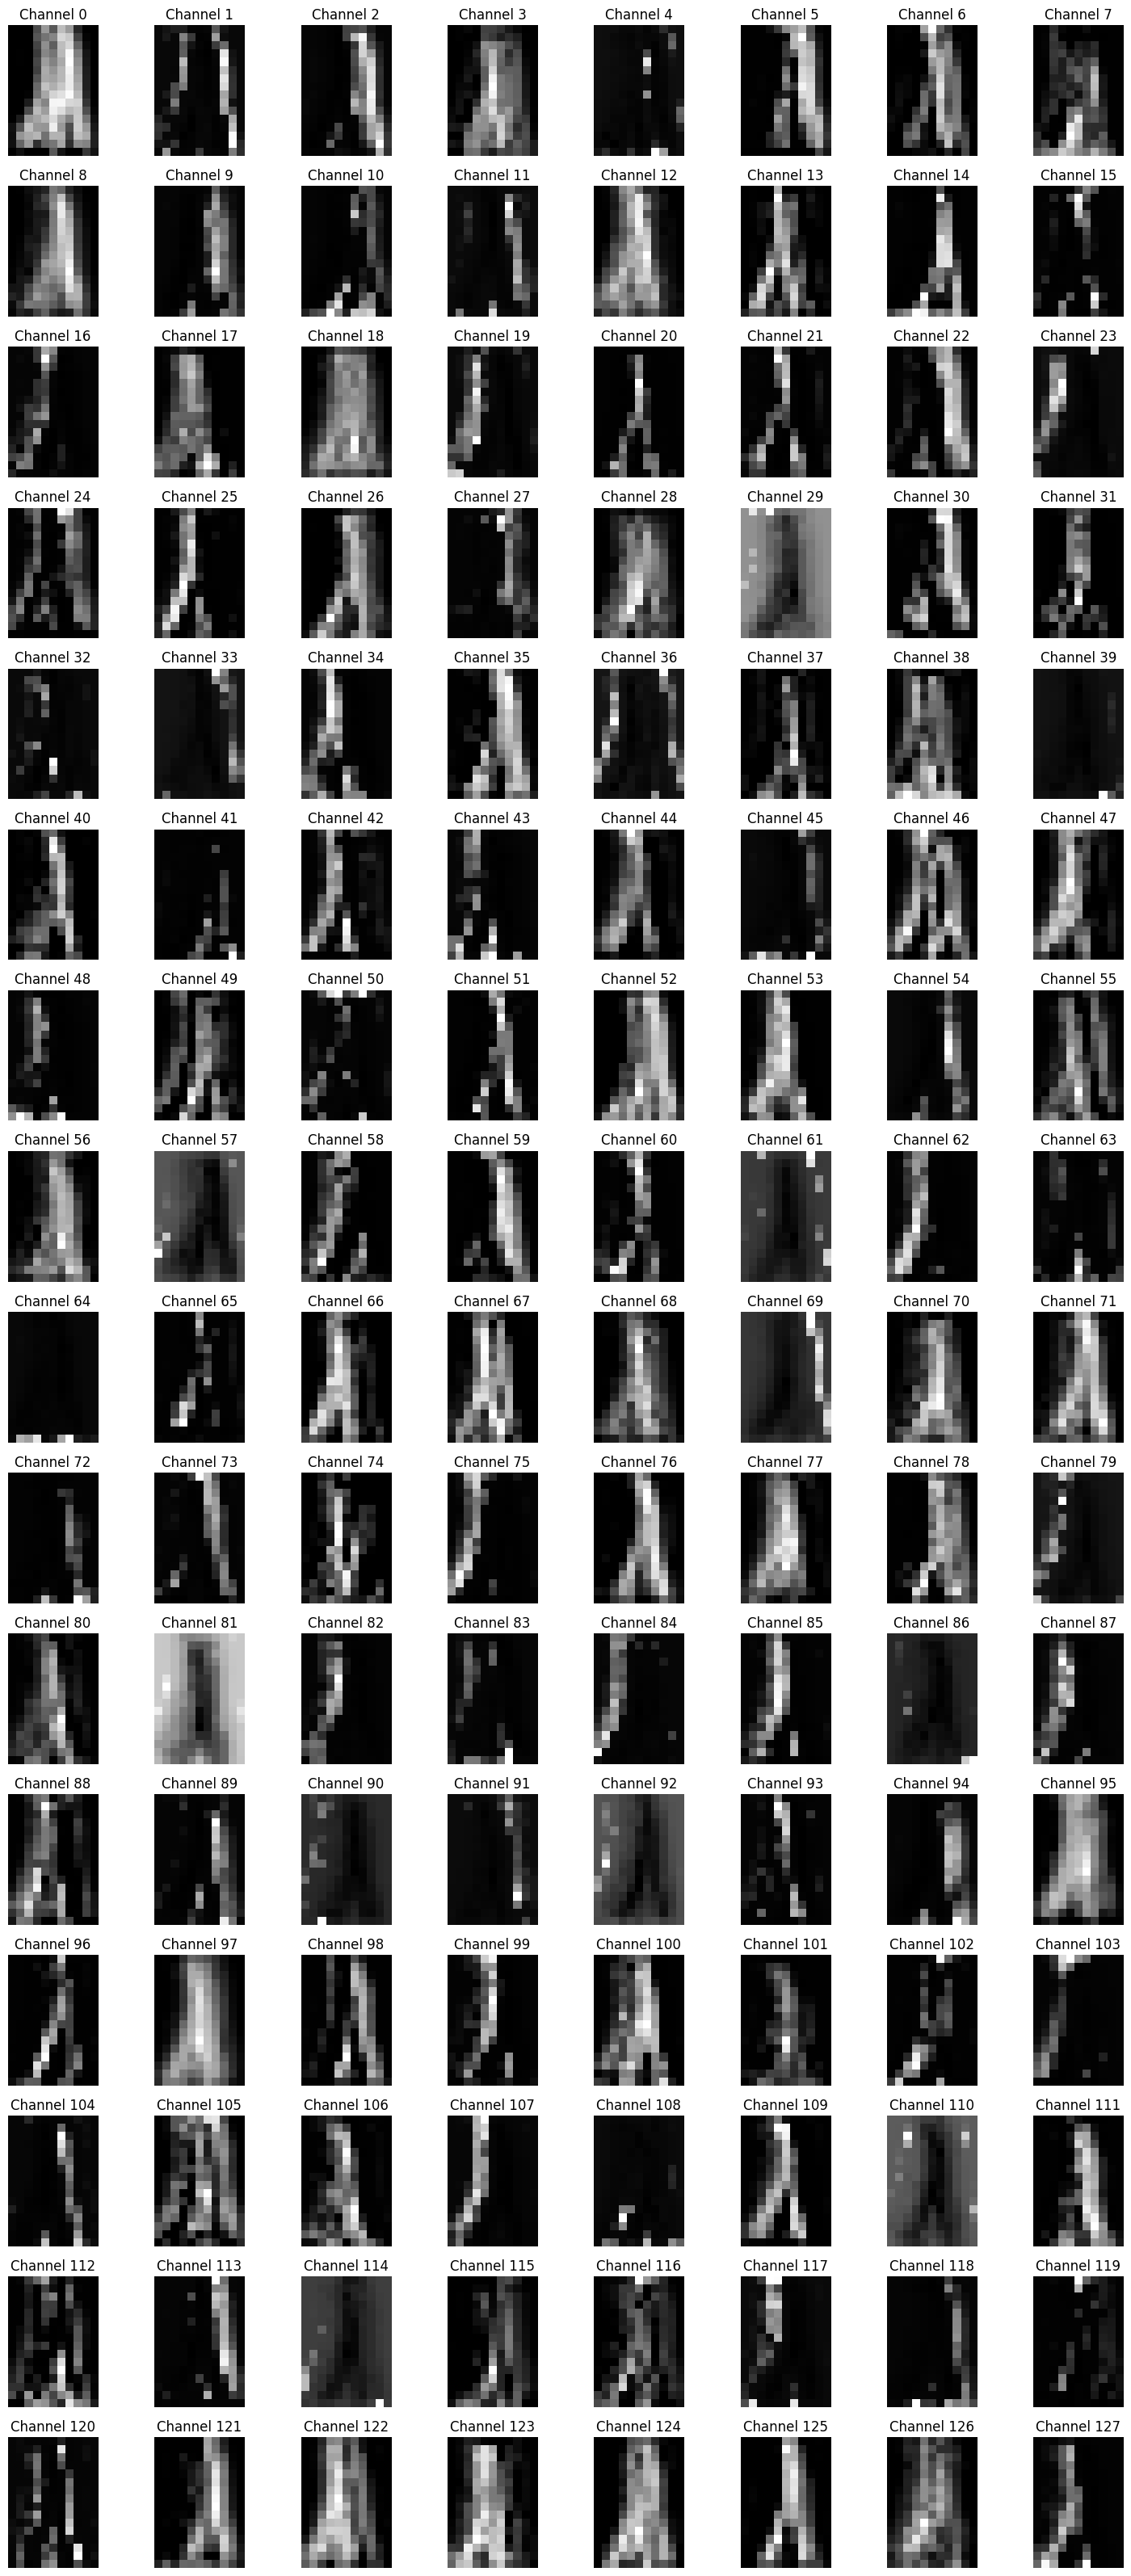

In [ ]:
img_layer5 = aa.set_layer5(img_layer4)
print(img_layer5.shape)
view_image_in_layer(img_layer5)

C6 (1, 128, 16, 16) * (128, 128, 16, 16) -> (1, 128 ,16, 16) (padding 1)

set_layer6: **nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)**
shape không đổi trước và sau:
- Input: (1, 1, 128, 16, 11)

- Output: (1, 1, 128, 16, 11)
- Mục tiêu:Dù không tăng số kênh, filter học thêm nhiều pattern mới, Tăng cường đặc trưng trước khi pooling


torch.Size([1, 1, 128, 16, 11])


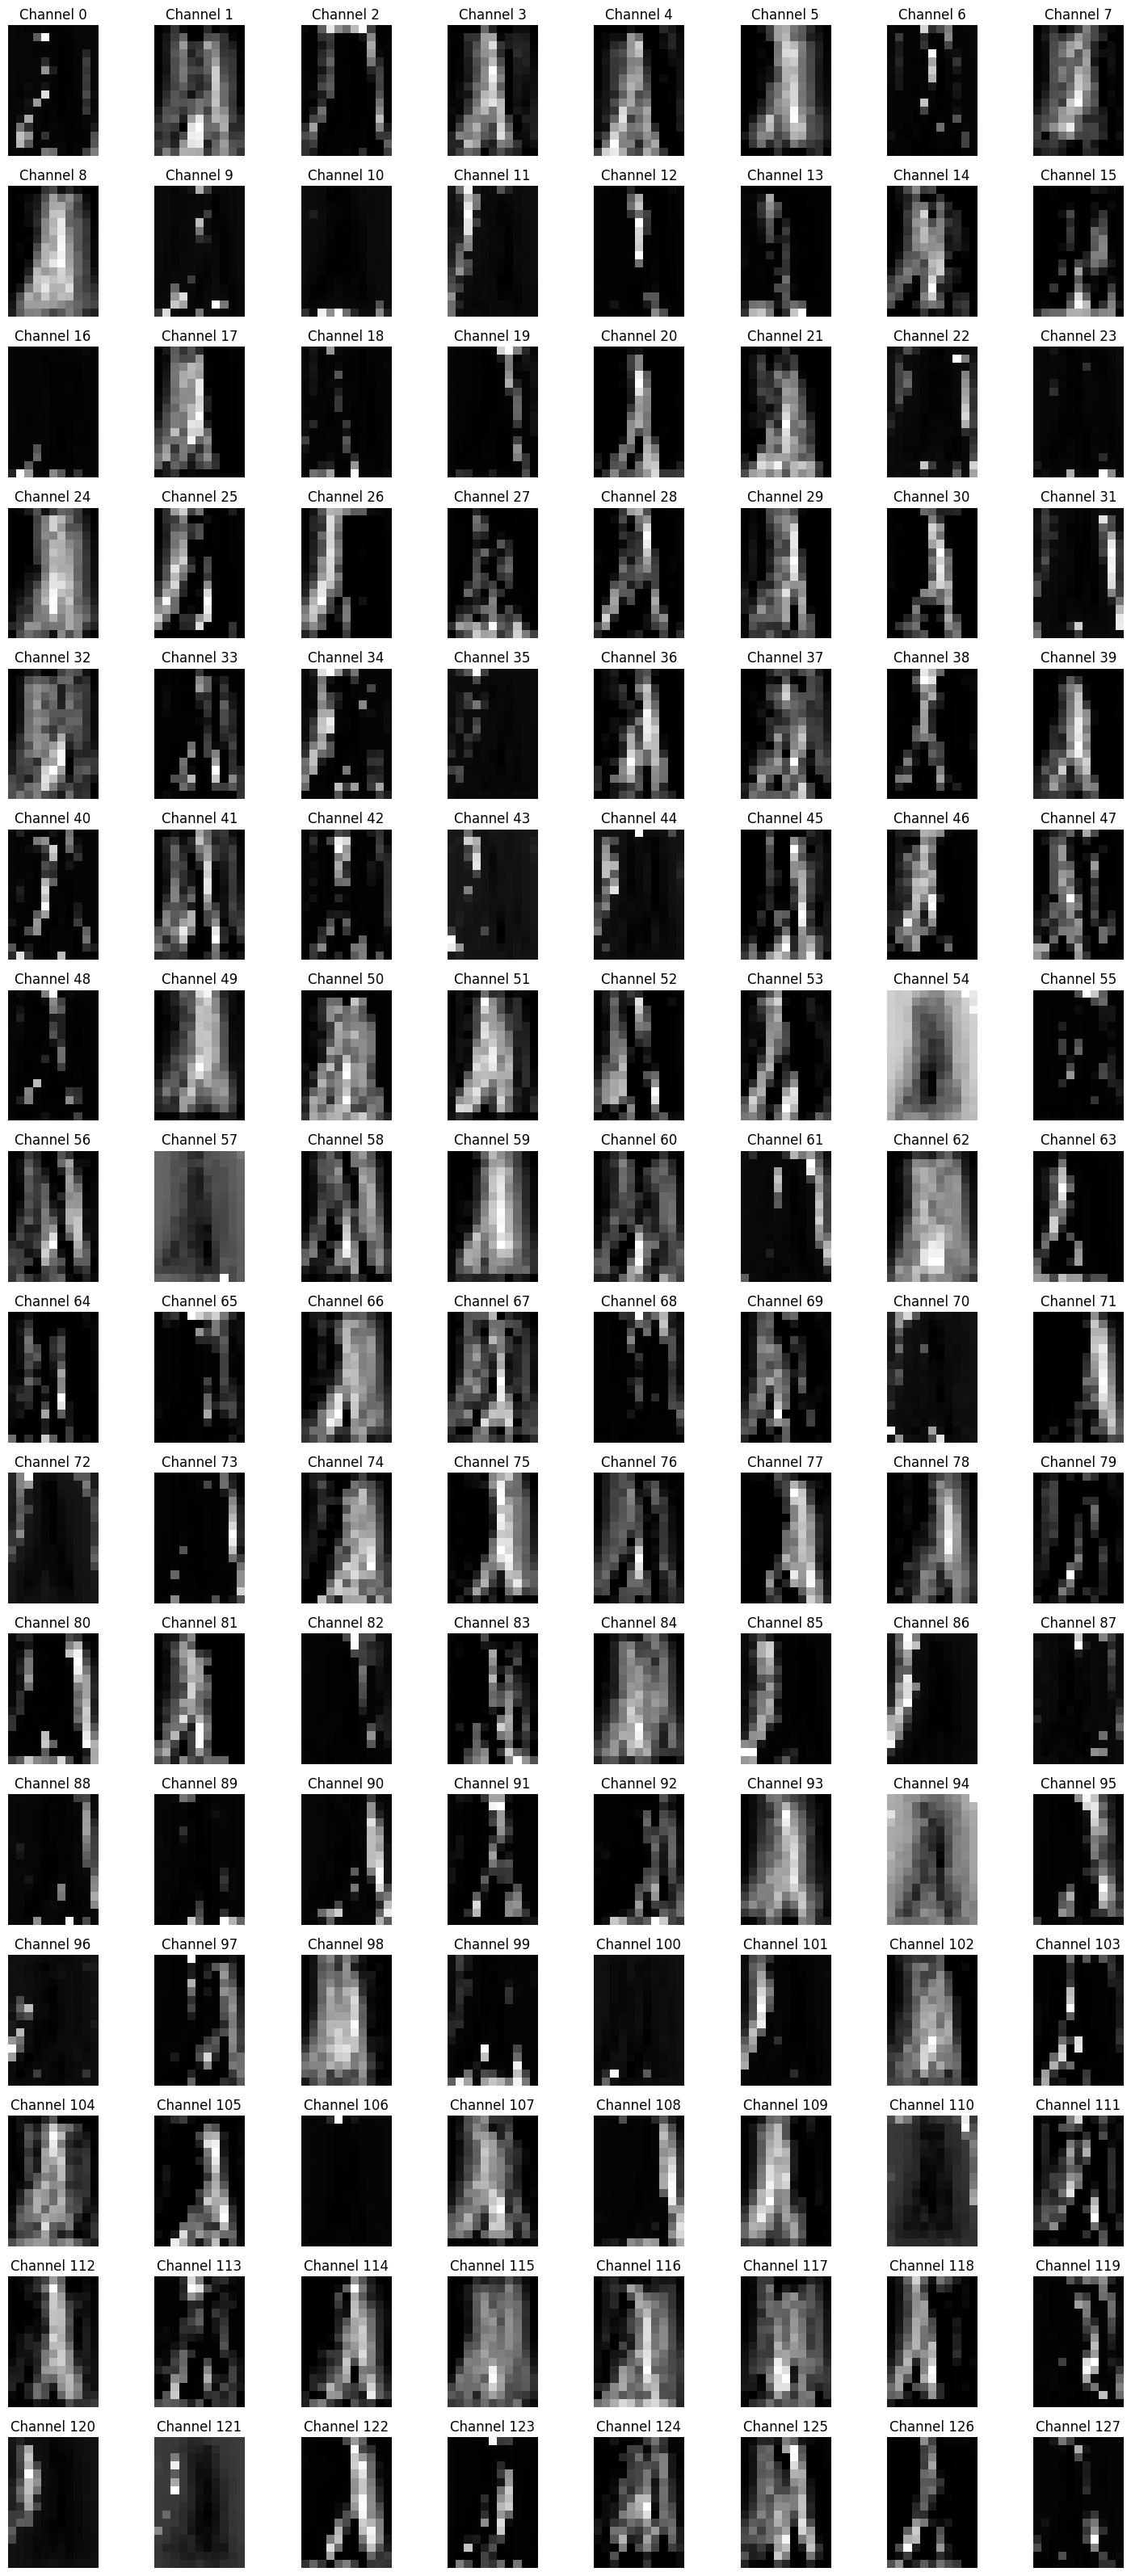

In [ ]:
img_layer6 = aa.set_layer6(img_layer5)
print(img_layer6.shape)
view_image_in_layer(img_layer6)

SP:
Gộp frame (tức các ảnh trong chuỗi dáng đi) lại thành một tensor duy nhất

Sử dụng phương pháp max pooling theo chiều thời gian

Lấy ra đặc trưng nổi bật nhất tại mỗi vị trí trên feature map
Nó gộp toàn bộ các frame của một chuỗi ảnh silhouette thành 1 tensor duy nhất bằng: frame_max = torch.max(x, dim=1, keepdim=True)
frame_max_6.shape = (1, 1, 128, 16, 11)
frame_max_6[0].shape = (1, 128, 16, 11)





torch.Size([1, 128, 16, 11])


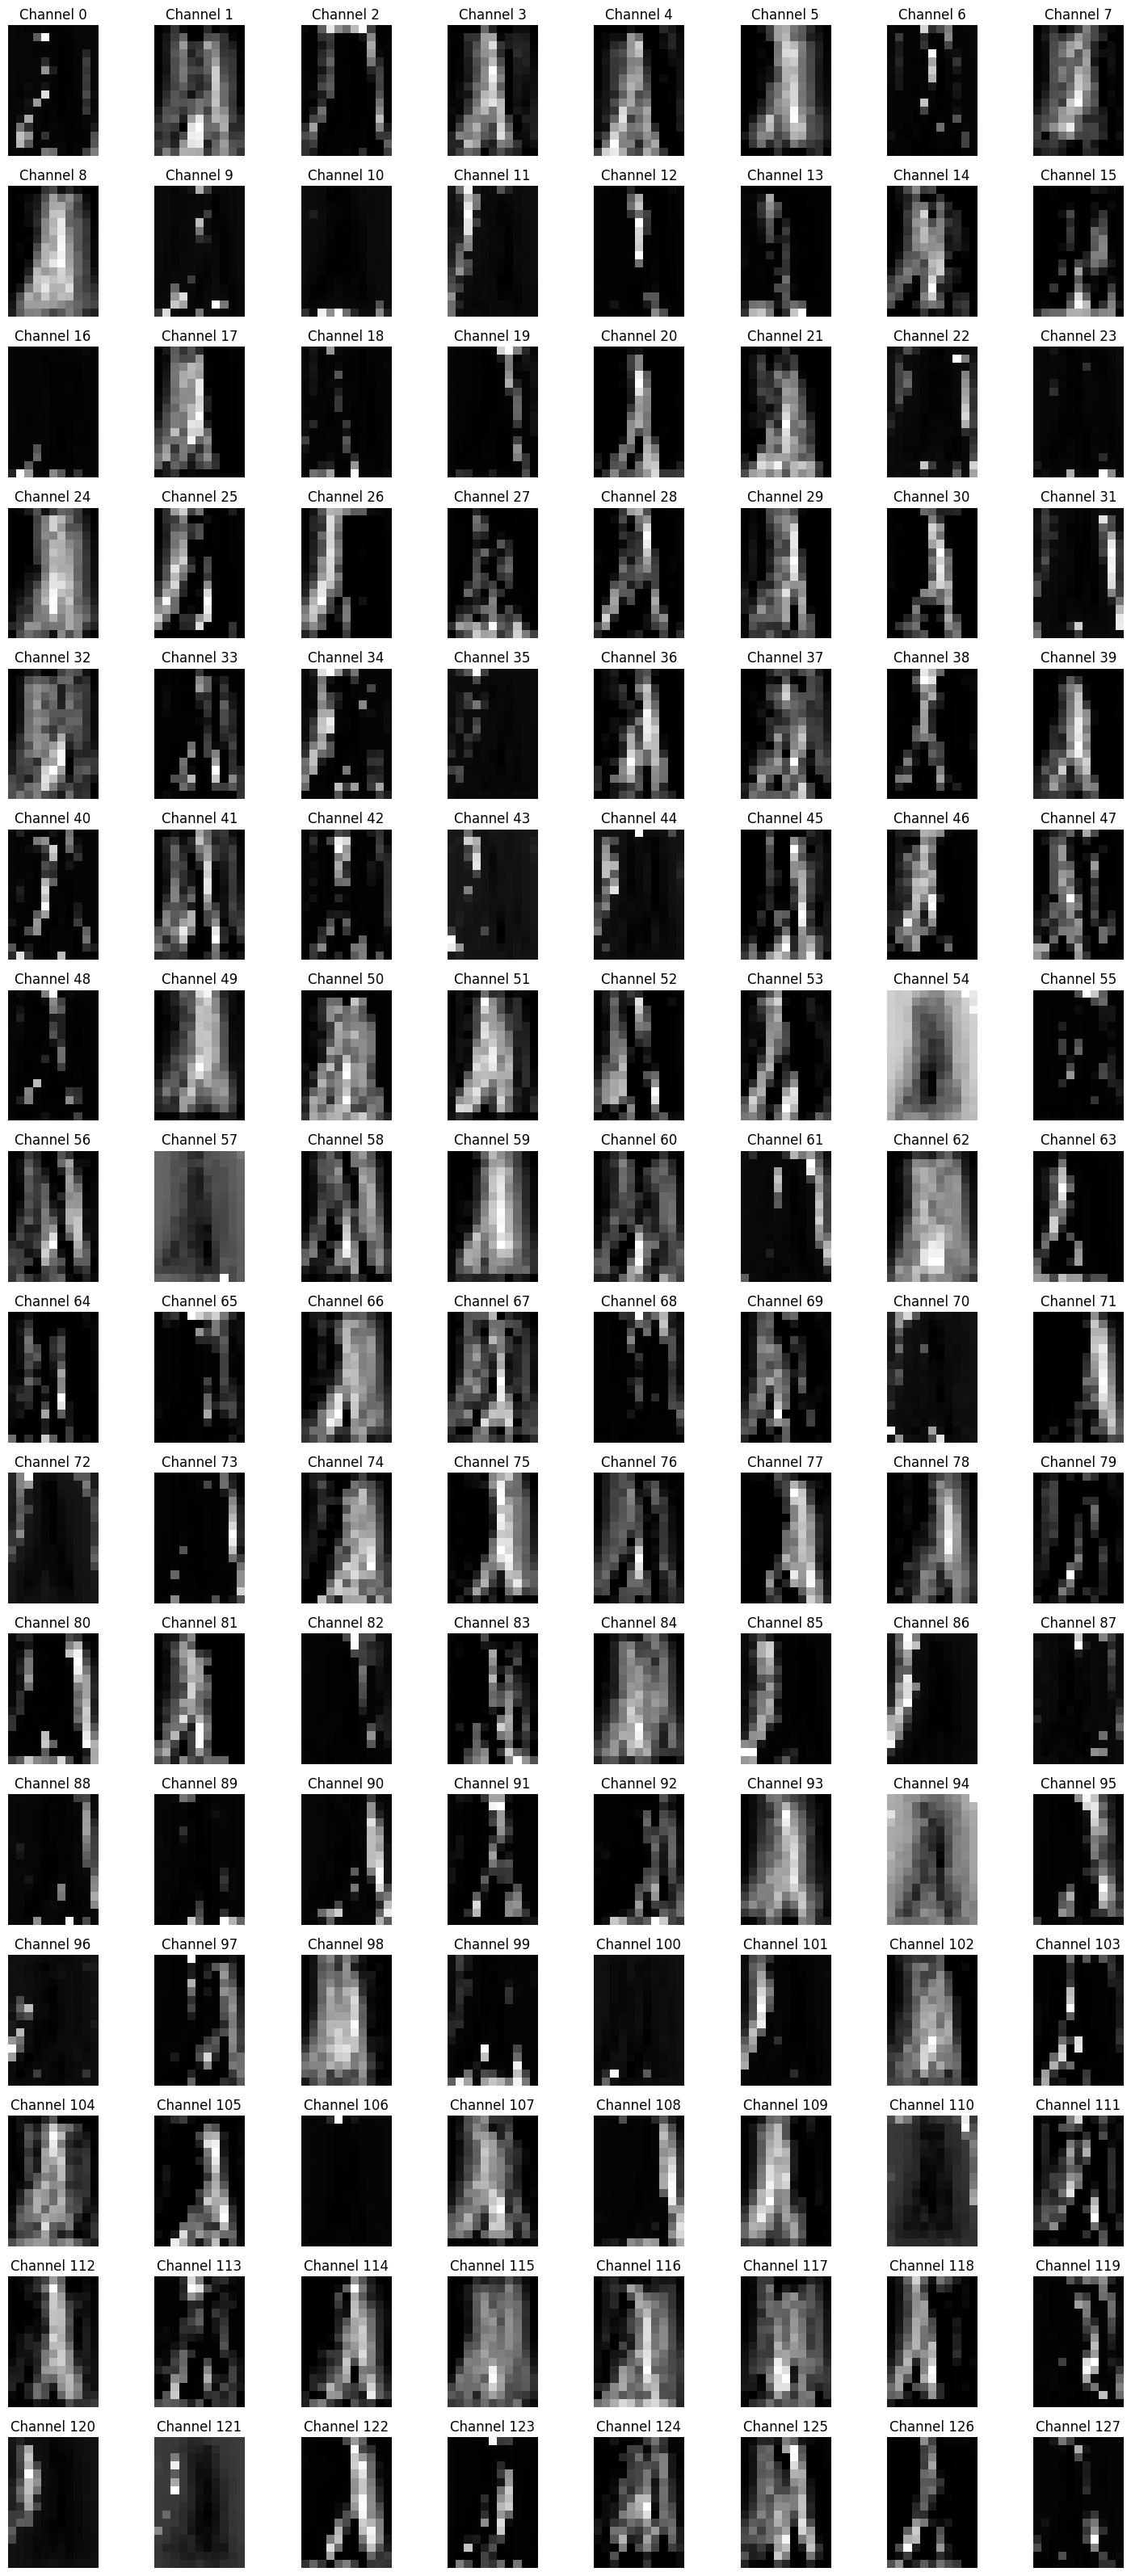

In [ ]:
frame_max_6 = aa.frame_max(img_layer6)
print(frame_max_6[0].shape)
view_image_in_layer(frame_max_6[0])

bước hợp nhất cuối cùng:
- Nhánh Set Branch (frame_max_6[0]) – đặc trưng trích từ nhiều frame silhouette .Các frame riêng lẻ (Set branch)

- Nhánh Global Branch (img_gl_layer4) – đặc trưng trích liên tục qua CNN từ đầu đến cuối.Dòng CNN liên tục (Global branch)

X.shape = (1, 128, 16, 11)

img_gl_layer4.shape = (1, 128, 16, 11)

torch.Size([1, 128, 16, 11])


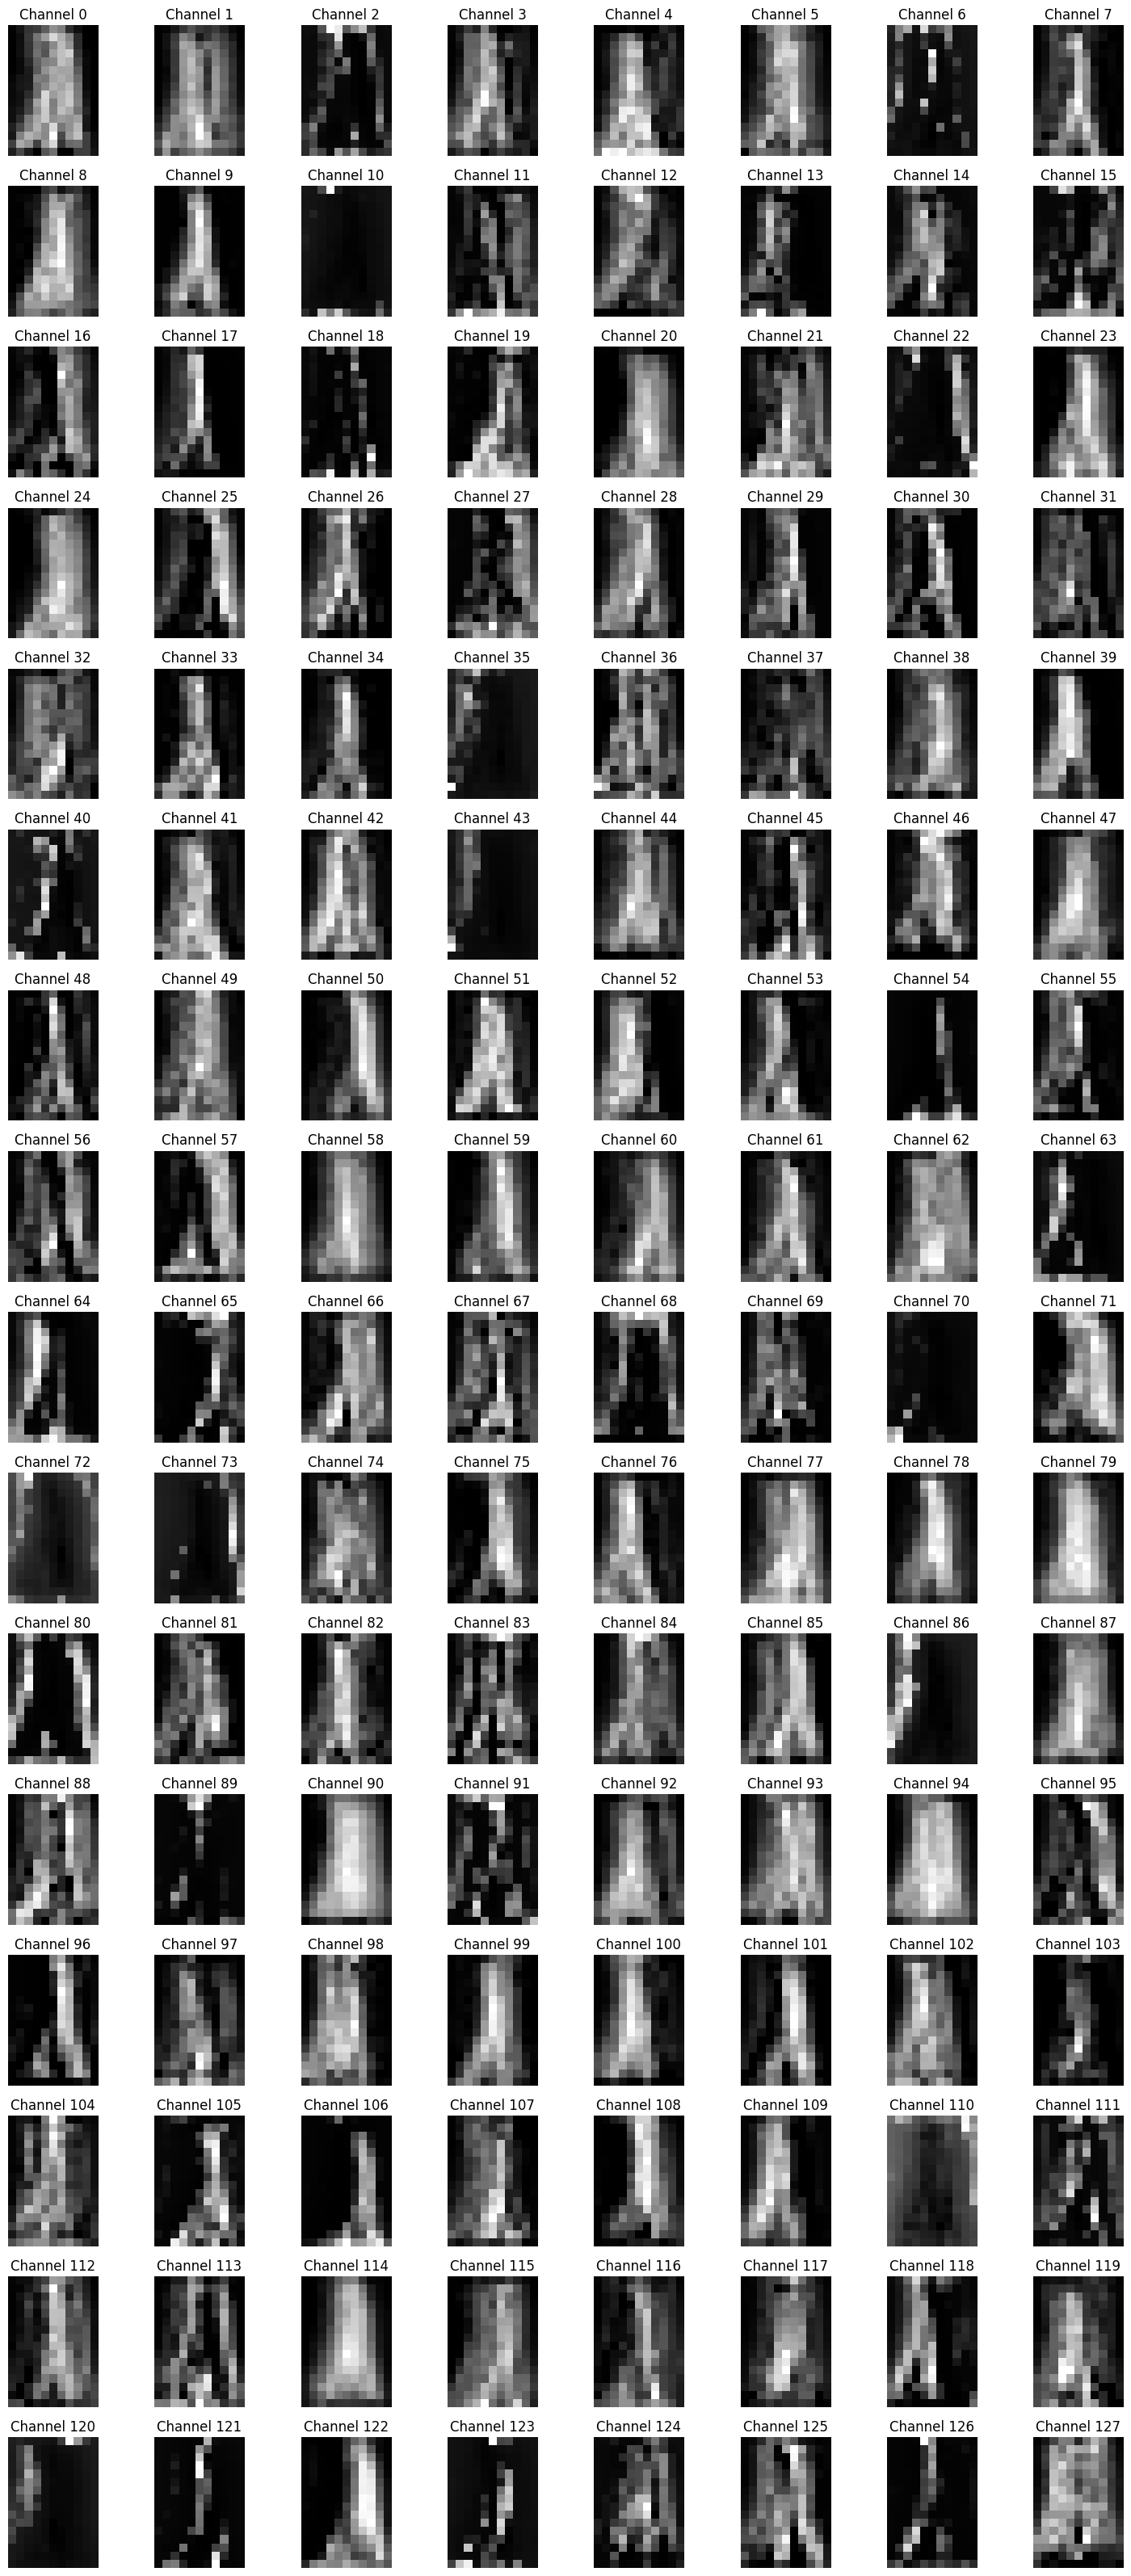

In [ ]:
X = frame_max_6[0]
gl = X + img_gl_layer4
print(gl.shape)
view_image_in_layer(gl)

Giai đoạn 4: HPM, chia đặc trưng thành nhiều vùng dọc, trích xuất đặc trưng trung bình + nổi bật, sau đó ghép lại, chiếu qua lớp học để tạo ra đặc trưng không gian mạnh mẽ theo chiều cao — giúp mô hình nhận diện dáng đi chính xác hơn.

Cắt tensor đặc trưng (X và gl) theo chiều cao thành các đoạn

Với mỗi đoạn:

- Áp dụng pooling (mean + max)

- Sau đó lưu lại

Nối tất cả lại → thành một vector duy nhất

Chiếu vector qua FC (fully connected layer) để giảm chiều và sinh ra embedding cuối



In [ ]:
#HPM: Chia vùng + mean + max pooling
feature = list()
n, c, h, w = gl.size()
for num_bin in aa.bin_num:
    z = X.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    feature.append(z)
    z = gl.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    feature.append(z)

for i in range(len(aa.bin_num) * 2):
    print(feature[i].size())
print("")

#HPM: Fully Connected per region
feature = torch.cat(feature, 2)
print(feature.size())

feature = feature.permute(2, 0, 1)
print(feature.size())

feature = feature.contiguous()
print(feature.size())
# print(feature)
print(aa.fc_bin[0].size())
feature = feature.matmul(aa.fc_bin[0])
print(feature.shape)
# print(feature)
feature = feature.permute(1, 0, 2).contiguous()
print(feature.shape)

torch.Size([1, 128, 1])
torch.Size([1, 128, 1])
torch.Size([1, 128, 2])
torch.Size([1, 128, 2])
torch.Size([1, 128, 4])
torch.Size([1, 128, 4])
torch.Size([1, 128, 8])
torch.Size([1, 128, 8])
torch.Size([1, 128, 16])
torch.Size([1, 128, 16])

torch.Size([1, 128, 62])
torch.Size([62, 1, 128])
torch.Size([62, 1, 128])
torch.Size([62, 128, 256])
torch.Size([62, 1, 256])
torch.Size([1, 62, 256])


Biến feature sẽ chứa một tensor có kích thước 256 chiều, chuẩn bị đưa vào Fully Connected Layers (FC)